In [6]:
import os
from collections import OrderedDict
from abc import ABC, abstractmethod

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import glob

import scanpy as sc
import anndata as ad

import torch
from torch_geometric.loader import DataLoader
import torch.optim as optim
import torch.nn.functional as F


import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

sc.set_figure_params(figsize=(5,5), frameon=False)

/home/rushing/miniconda3/envs/GMT/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
run_name = "Graph-Perciever_September-17"
fold_idx = 2
features_path = os.path.join("/SeaExp/Rushin/TNTA/logs/", run_name+"_fold_{}".format(fold_idx))
features_path

'/SeaExp/Rushin/TNTA/logs/Graph-Perciever_September-17_fold_2'

In [62]:
all_samples_df = pd.read_csv(os.path.join(features_path, 'model_metadata.csv'), header=0, index_col=0)
all_samples_df['Dataset_Name'] = all_samples_df['Dataset_Name'].str.replace('Dataset', '', regex=True)
all_samples_df['Dataset_Name'] = all_samples_df['Dataset_Name'].str.upper()
all_samples_df['Bulk_Label'] = all_samples_df['Ground_Truth']
all_samples_df.loc[all_samples_df['Dataset_Name']=='PCGA', 'Bulk_Label'] = 'premalignant'
all_samples_df.head()

Slide_Name Ground_Truth Hard_Class  Prob_Confidence Dataset_Name  \
0  C3L-02660-26       normal     normal          0.98666        CPTAC   
1  C3N-00572-26       normal     normal          1.00000        CPTAC   
2  C3L-01884-26       normal     normal          1.00000        CPTAC   
3  C3N-02158-27       normal     normal          1.00000        CPTAC   
4  C3N-02434-27       normal     normal          1.00000        CPTAC   

  Bulk_Label  
0     normal  
1     normal  
2     normal  
3     normal  
4     normal

In [63]:
if not os.path.exists(os.path.join(features_path, 'all_samples_adata.h5ad')):
    print("Creating all_samples h5 file NOW")
    X = []
    for idx, row in all_samples_df.iterrows():
        path = os.path.join(features_path, row['Dataset_Name'], 'slide_features', row['Slide_Name']+".pt")
        X.append(torch.load(path).cpu().numpy()[0])
        
    all_features = np.array(X)
    features_adata = ad.AnnData(X=all_features,
                                obs={'cohort_names': np.array(all_samples_df['Dataset_Name']),
                                    'labels': np.array(all_samples_df['Ground_Truth']),
                                    'bulk_labels': np.array(all_samples_df['Bulk_Label']),
                                    'model_predictions': np.array(all_samples_df['Hard_Class'])
                                    })
    features_adata.obs_names = all_samples_df['Slide_Name']

    features_adata.write_h5ad(os.path.join(features_path, 'all_samples_adata.h5ad'))

features_adata = sc.read_h5ad(os.path.join(features_path, 'all_samples_adata.h5ad'))
features_adata.obs.loc[features_adata.obs['labels'] == 'cis','bulk_labels'] = 'cis'
# sc.tl.leiden(features_adata, resolution=0.05)

""" cis_only = features_adata[features_adata.obs['cohort_names'] == 'CIS'].copy()
cis_only.write_h5ad(os.path.join(features_path, 'cis_adata.h5ad'))

pcga_only = features_adata[features_adata.obs['cohort_names'] == 'PCGA'].copy()
pcga_only.write_h5ad(os.path.join(features_path, 'pcga_adata.h5ad'))

cptac_only = features_adata[features_adata.obs['cohort_names'] == 'CPTAC'].copy()
cptac_only.write_h5ad(os.path.join(features_path, 'cptac_adata.h5ad')) """

features_adata.obs['bulk_labels'].unique()

['normal', 'lusc', 'luad', 'cis', 'premalignant']
Categories (5, object): ['cis', 'luad', 'lusc', 'normal', 'premalignant']

In [64]:
# Define a continuous colormap
cmap_continuous = plt.get_cmap('RdBu')

# Create a discrete colormap from the continuous one
n_colors = 5
# Create a discrete colormap at regular intervals from the continuous colormap
cmap_discrete = ListedColormap([cmap_continuous(i) for i in np.linspace(0, 1, n_colors)])

# Get the hex codes of the colors in the colormap
hex_codes = [mpl.colors.to_hex(color) for color in cmap_discrete.colors]
print(hex_codes)

['#67001f', '#e58368', '#f6f7f7', '#68abd0', '#053061']


In [65]:
def define_colors(features_adata):

    colors = ["#ffffcc", "#a1dab4", "#41b6c4", "#2c7fb8", "#253494"]
    lima_blue = ListedColormap(colors, name="lima_blue")
    lima_blue_r = lima_blue.reversed()

    features_adata.uns['bulk_labels_colors'] = ["#2c7fb8", "#67001f", "#053061", "#eed7ff", "#a1dab4"]
    features_adata.uns['bulk_merge_labels_colors'] = ["#67001f", "#053061", "#eed7ff", "#a1dab4"]

    features_adata.obs['bulk_merge_labels'] = features_adata.obs['bulk_labels']
    features_adata.obs['bulk_merge_labels'].replace(['cis'], 'premalignant', inplace=True)

    return features_adata

In [66]:
features_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions'

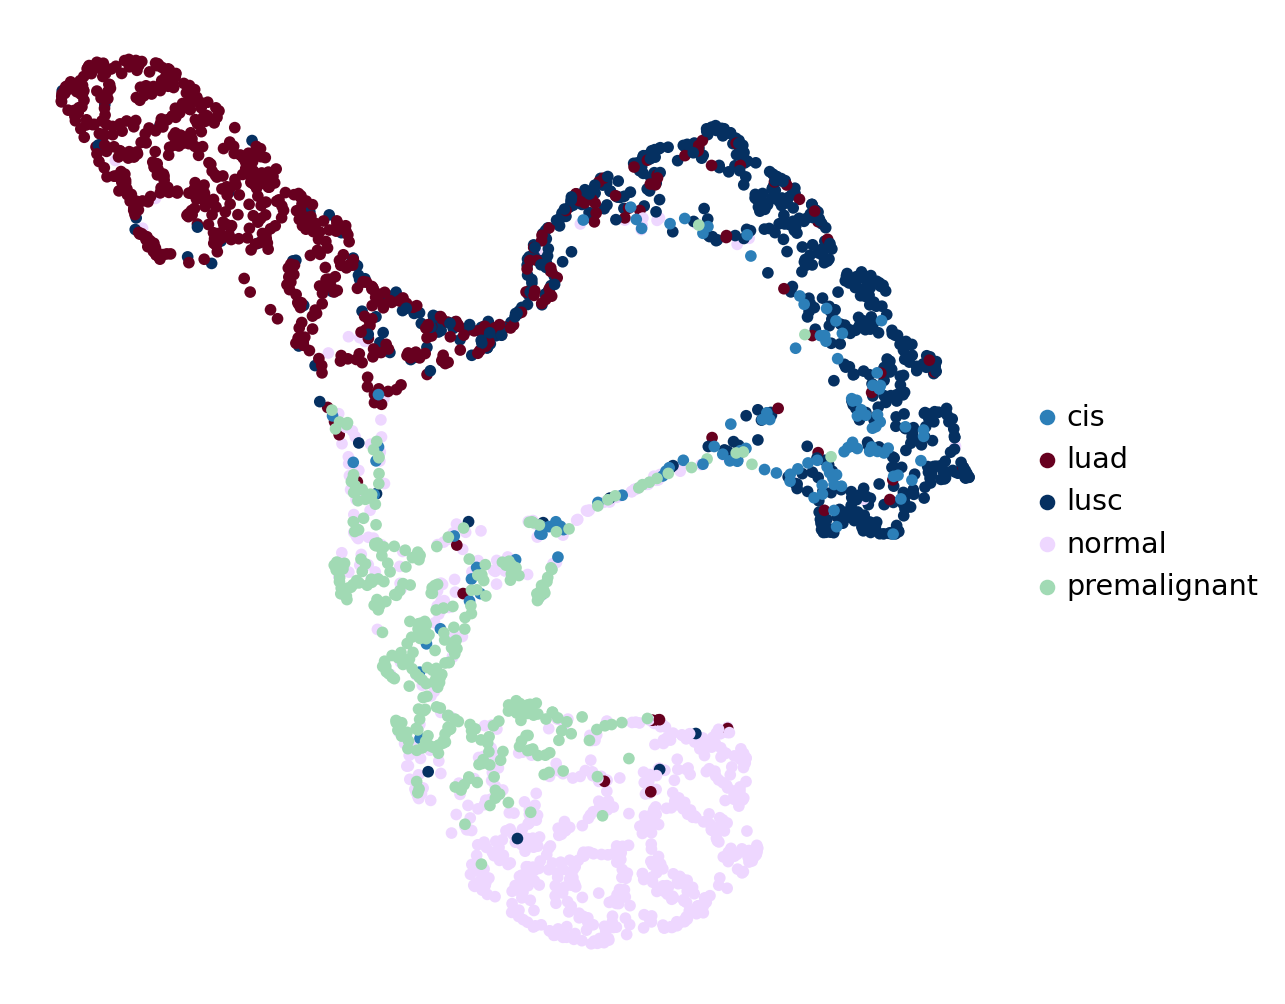

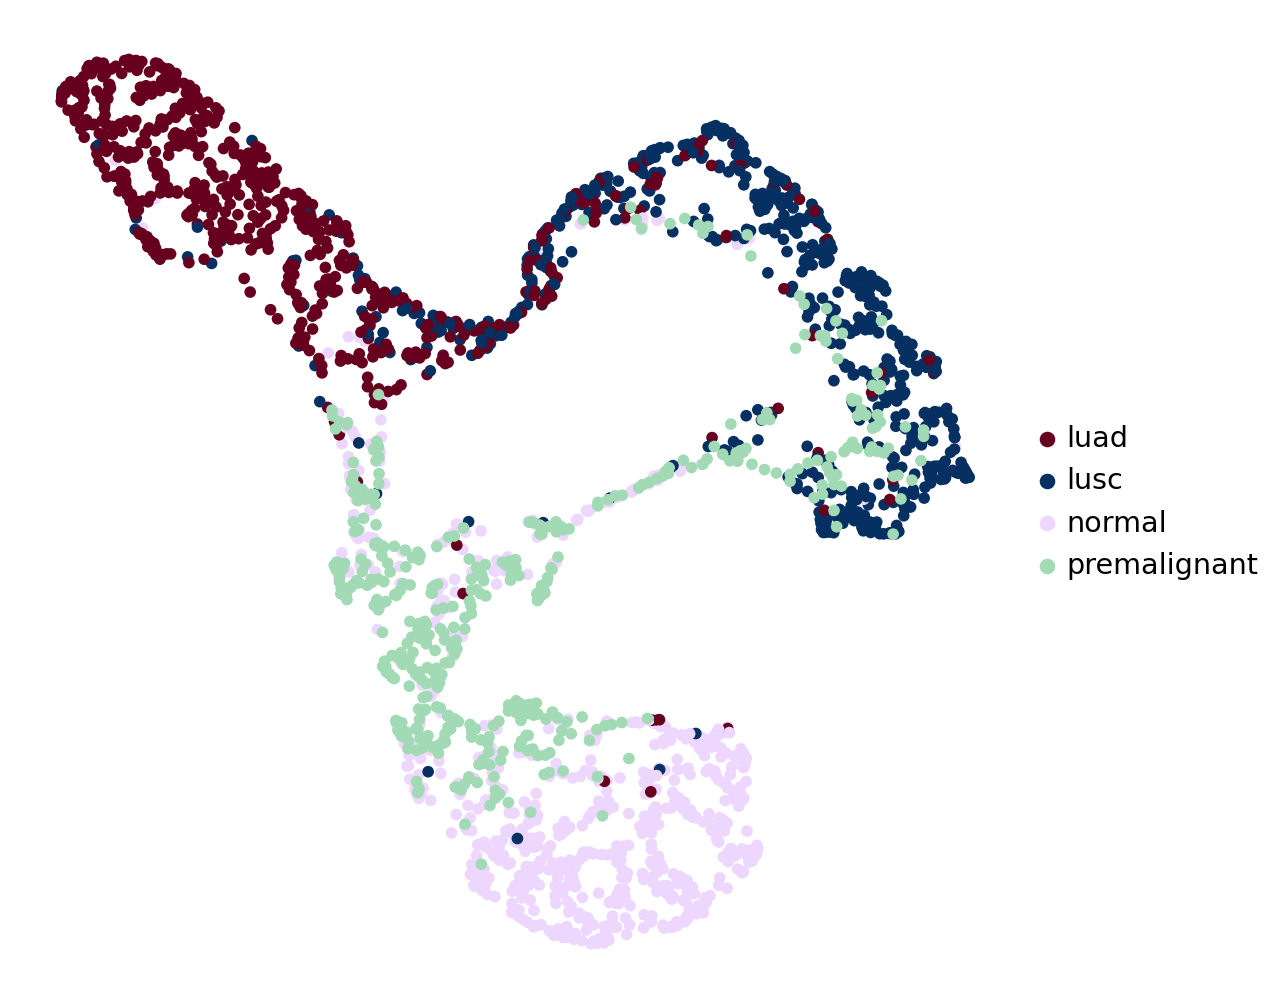

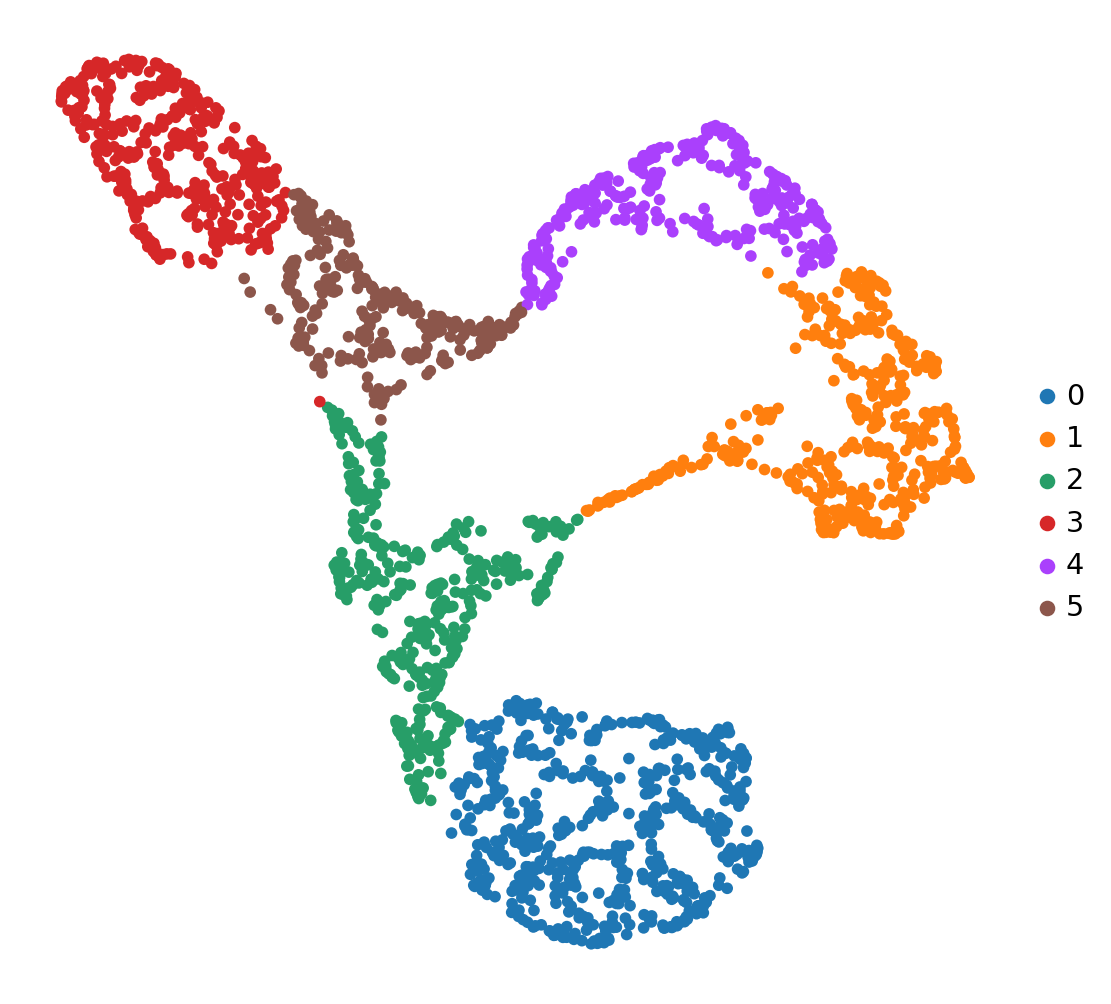

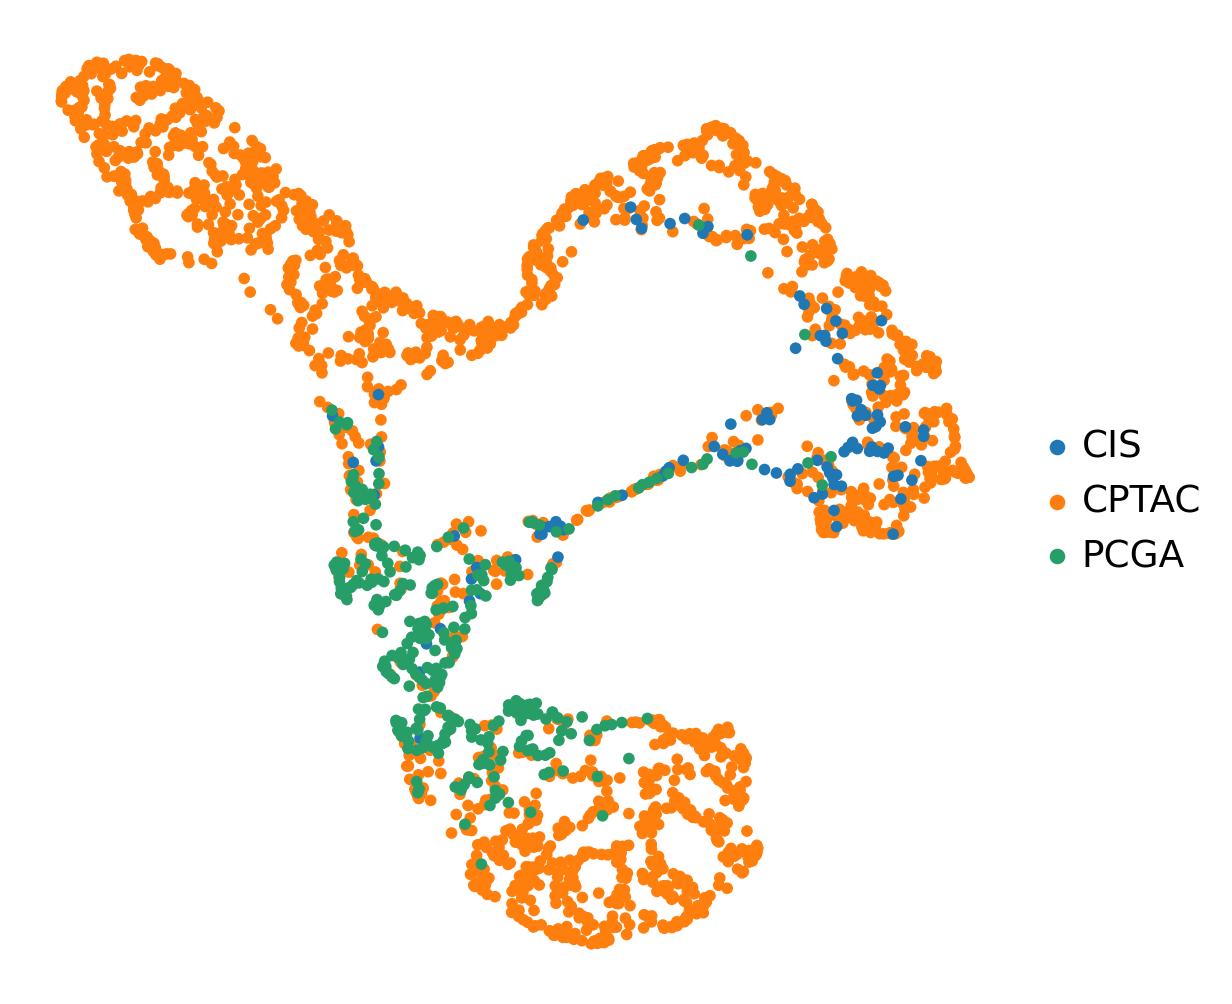

In [67]:
sc.tl.pca(features_adata, svd_solver='arpack')
sc.pp.neighbors(features_adata, use_rep='X_pca')

sc.tl.paga(features_adata, groups='bulk_labels')
sc.pl.paga(features_adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(features_adata, init_pos='paga', min_dist=0.3)
# sc.tl.umap(features_adata)
sc.tl.tsne(features_adata, use_rep='X')
sc.tl.leiden(features_adata, resolution=0.1)

features_adata = define_colors(features_adata)

with plt.rc_context({'figure.figsize': (8, 8)}):
    sc.pl.umap(features_adata, color=['bulk_labels'], title=[''], frameon=False, wspace=0.4, s=110, save='all_inclusive.pdf')
    sc.pl.umap(features_adata, color=['bulk_merge_labels'], title=[''], frameon=False, wspace=0.4, s=110, save='bulk_merge.pdf')
    sc.pl.umap(features_adata, color=['leiden'], title=[''], frameon=False, wspace=0.4, s=110, save='leiden.pdf')
    sc.pl.umap(features_adata, color=['cohort_names'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=False, na_color='w', s=110, save='cohort_names.pdf')

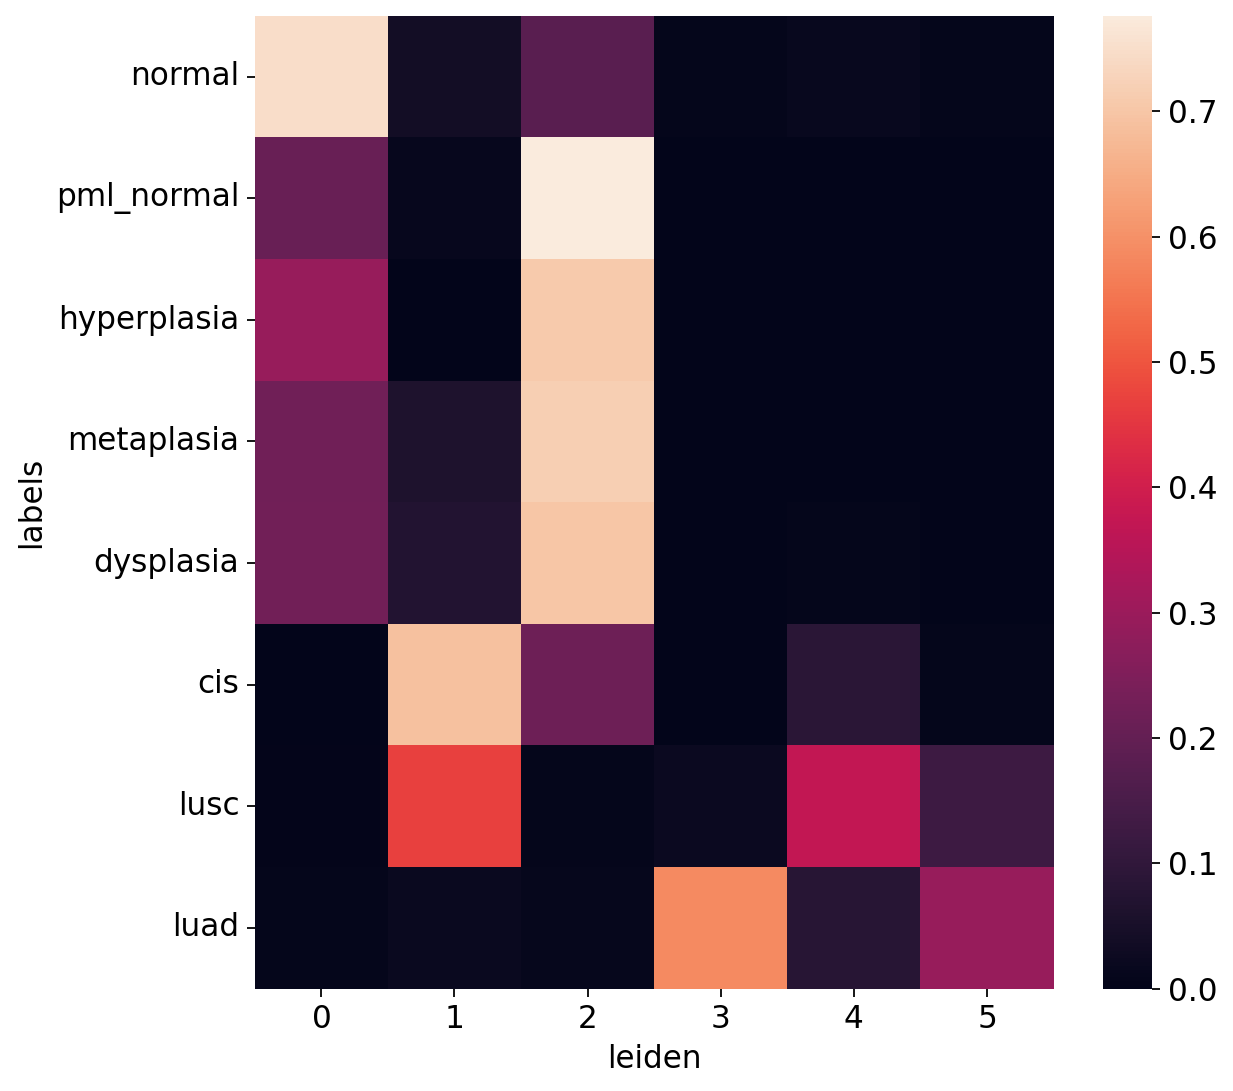

In [68]:
import seaborn as sns
cmtx = sc.metrics.confusion_matrix("labels", "leiden", features_adata.obs)
# print(cmtx)
# sort cmtx by index following the list: [normal, pml_normal, hyperplasia, metaplasia, dysplasia, cis, lusc, luad]
cmtx = cmtx.reindex(index=['normal', 'pml_normal', 'hyperplasia', 'metaplasia', 'dysplasia', 'cis', 'lusc', 'luad'])
with plt.rc_context({'figure.figsize': (8, 8)}):
    cm = sns.heatmap(cmtx)
    fig = cm.get_figure()
    fig.savefig('figures/leiden_corr_labels.pdf')
    # save heatmap as pdf


In [69]:
sc.tl.embedding_density(features_adata, basis='umap', groupby='labels')
features_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels'
    uns: 'pca', 'neighbors', 'paga', 'bulk_labels_sizes', 'umap', 'tsne', 'leiden', 'bulk_labels_colors', 'bulk_merge_labels_colors', 'leiden_colors', 'cohort_names_colors', 'umap_density_labels_params'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

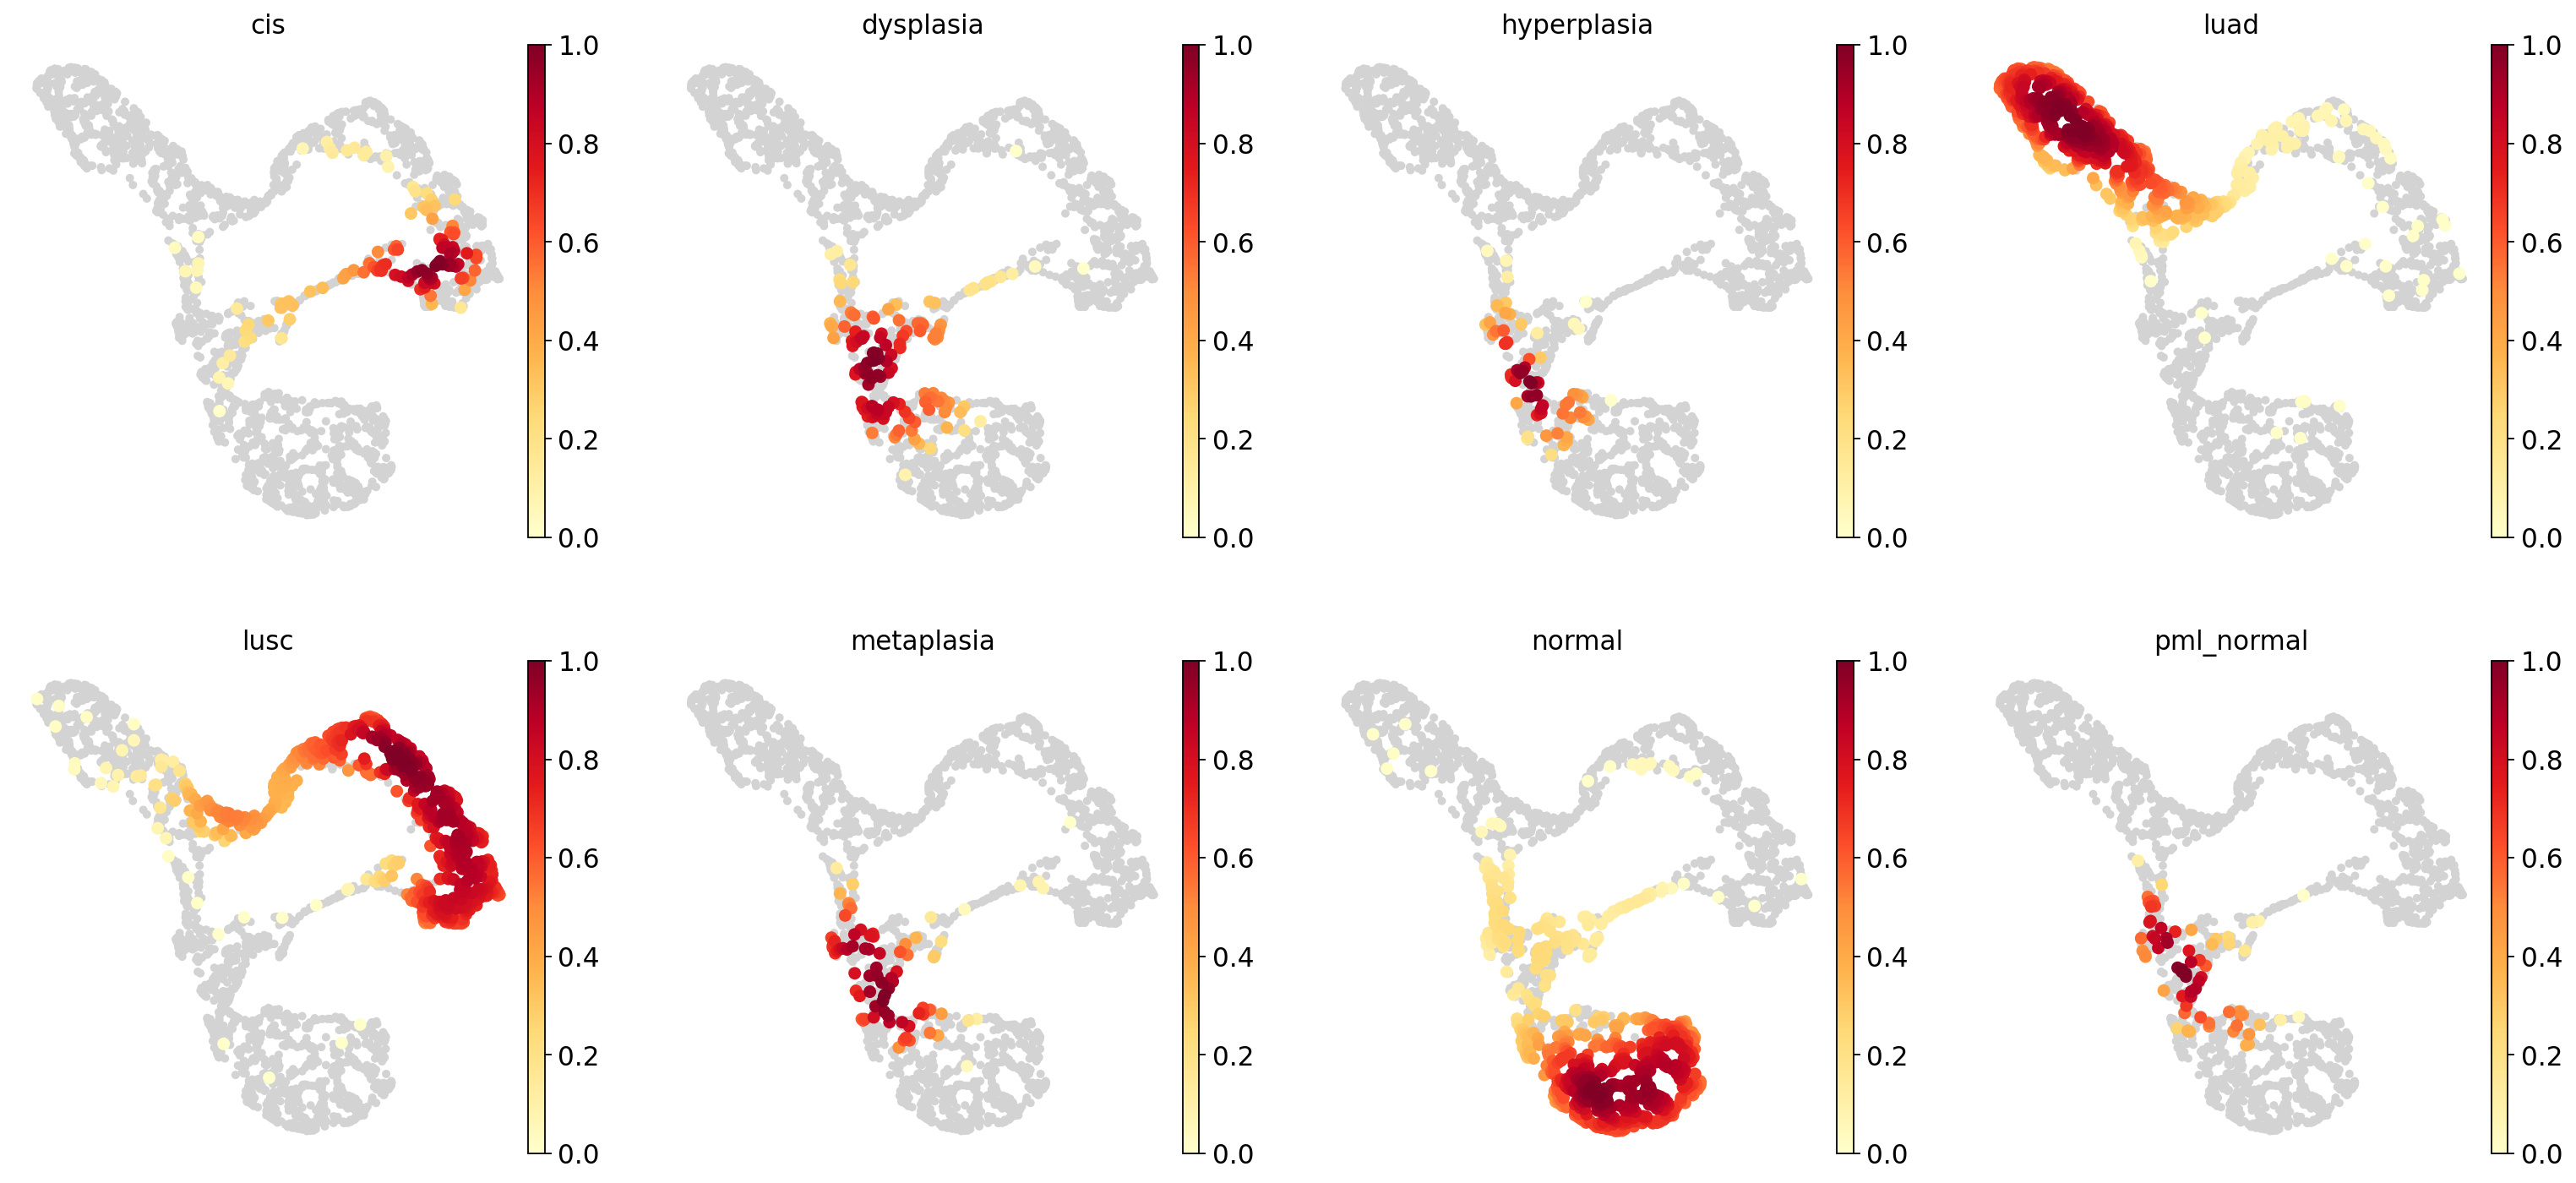

In [70]:
sc.pl.embedding_density(features_adata, basis='umap', key='umap_density_labels', save='umap_density_labels.pdf')

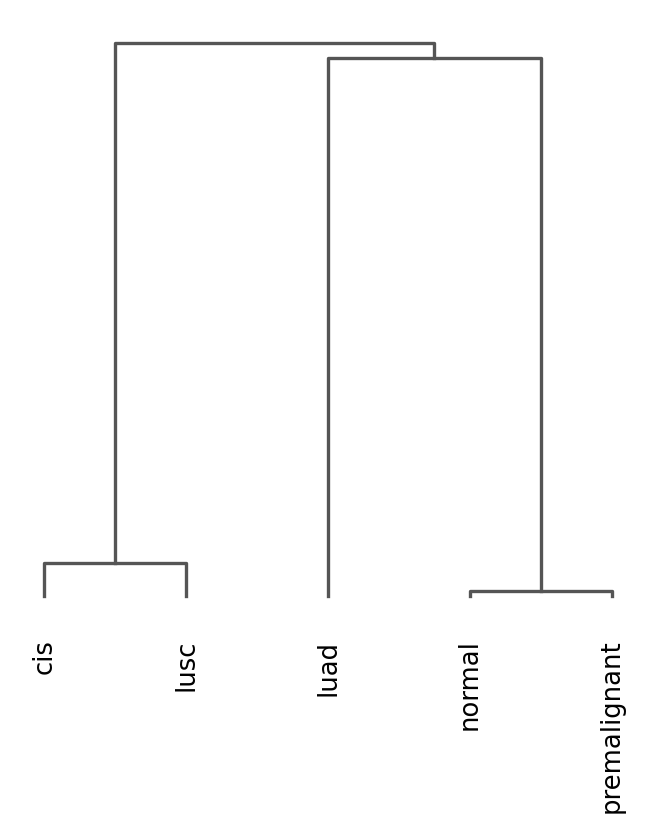

<AxesSubplot: >

In [71]:
sc.tl.dendrogram(features_adata, groupby='bulk_labels')
sc.pl.dendrogram(features_adata, groupby='bulk_labels')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


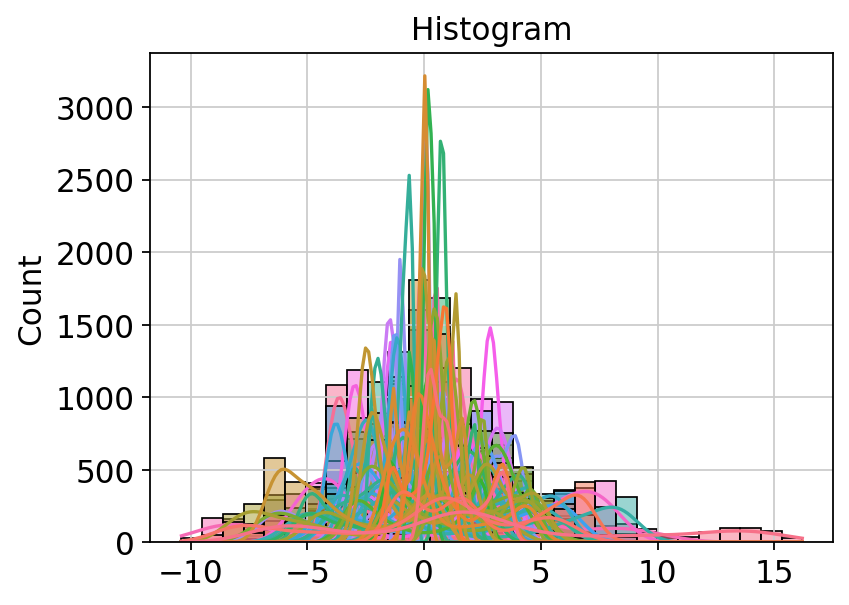

In [72]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Assuming 'features' is a numpy array of your features
features = features_adata.X  # Replace with your actual features

# Histogram
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.histplot(features, kde=True, bins=30)
plt.title('Histogram')

# don't show the legend
plt.legend().set_visible(False)

plt.tight_layout()
plt.show()

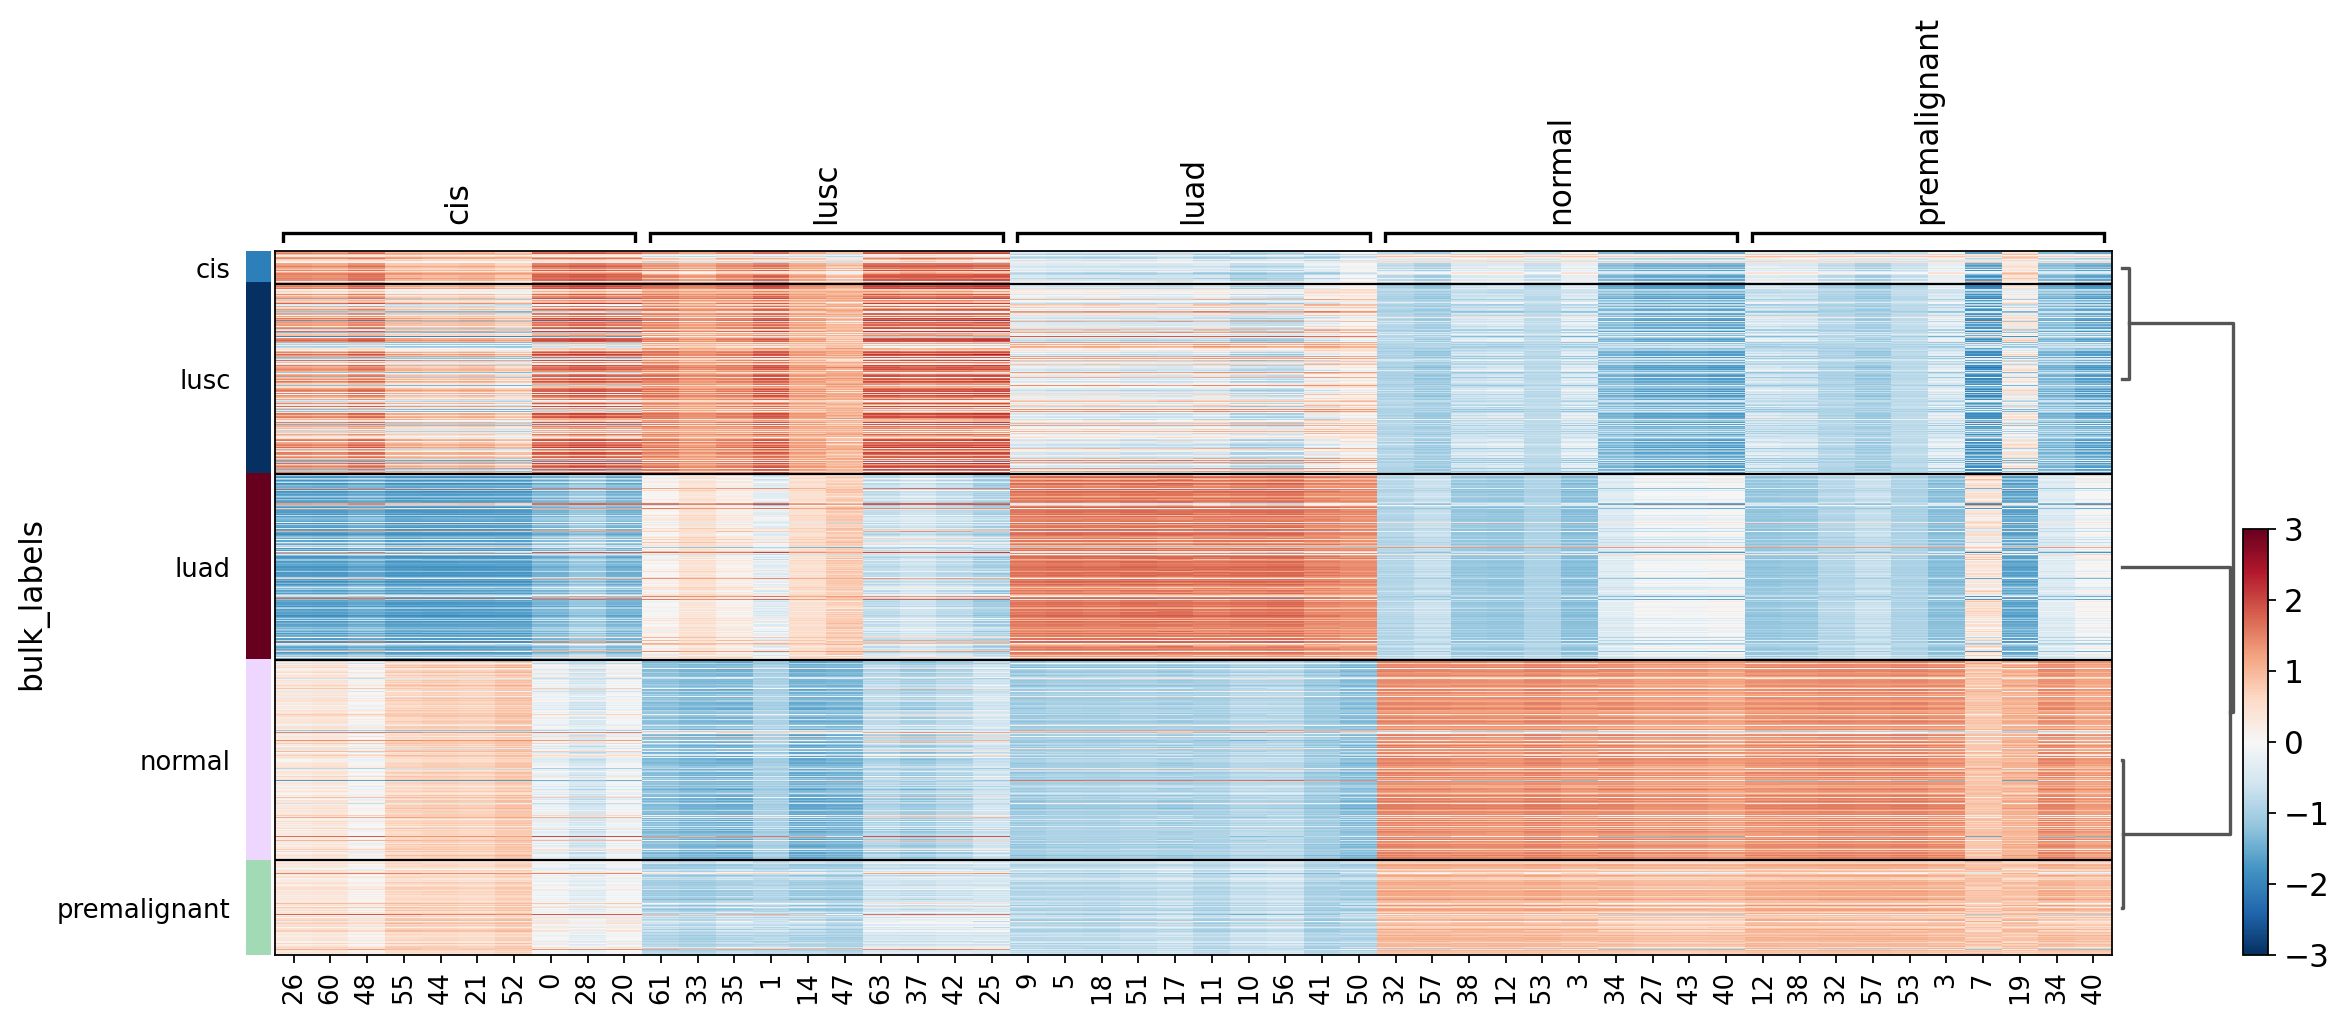

In [73]:
features_adata.layers['scaled'] = sc.pp.scale(features_adata, copy=True).X
sc.tl.rank_genes_groups(features_adata, groupby='bulk_labels', method='t-test', pts=True, key_added='rank_features_ttest_bulk_labels', layer='scaled')
sc.pl.rank_genes_groups_heatmap(features_adata, show_gene_labels=True, key='rank_features_ttest_bulk_labels', vmin=-3, vmax=3, cmap='RdBu_r', layer='scaled', save='rank_features_ttest_bulk_labels.pdf')

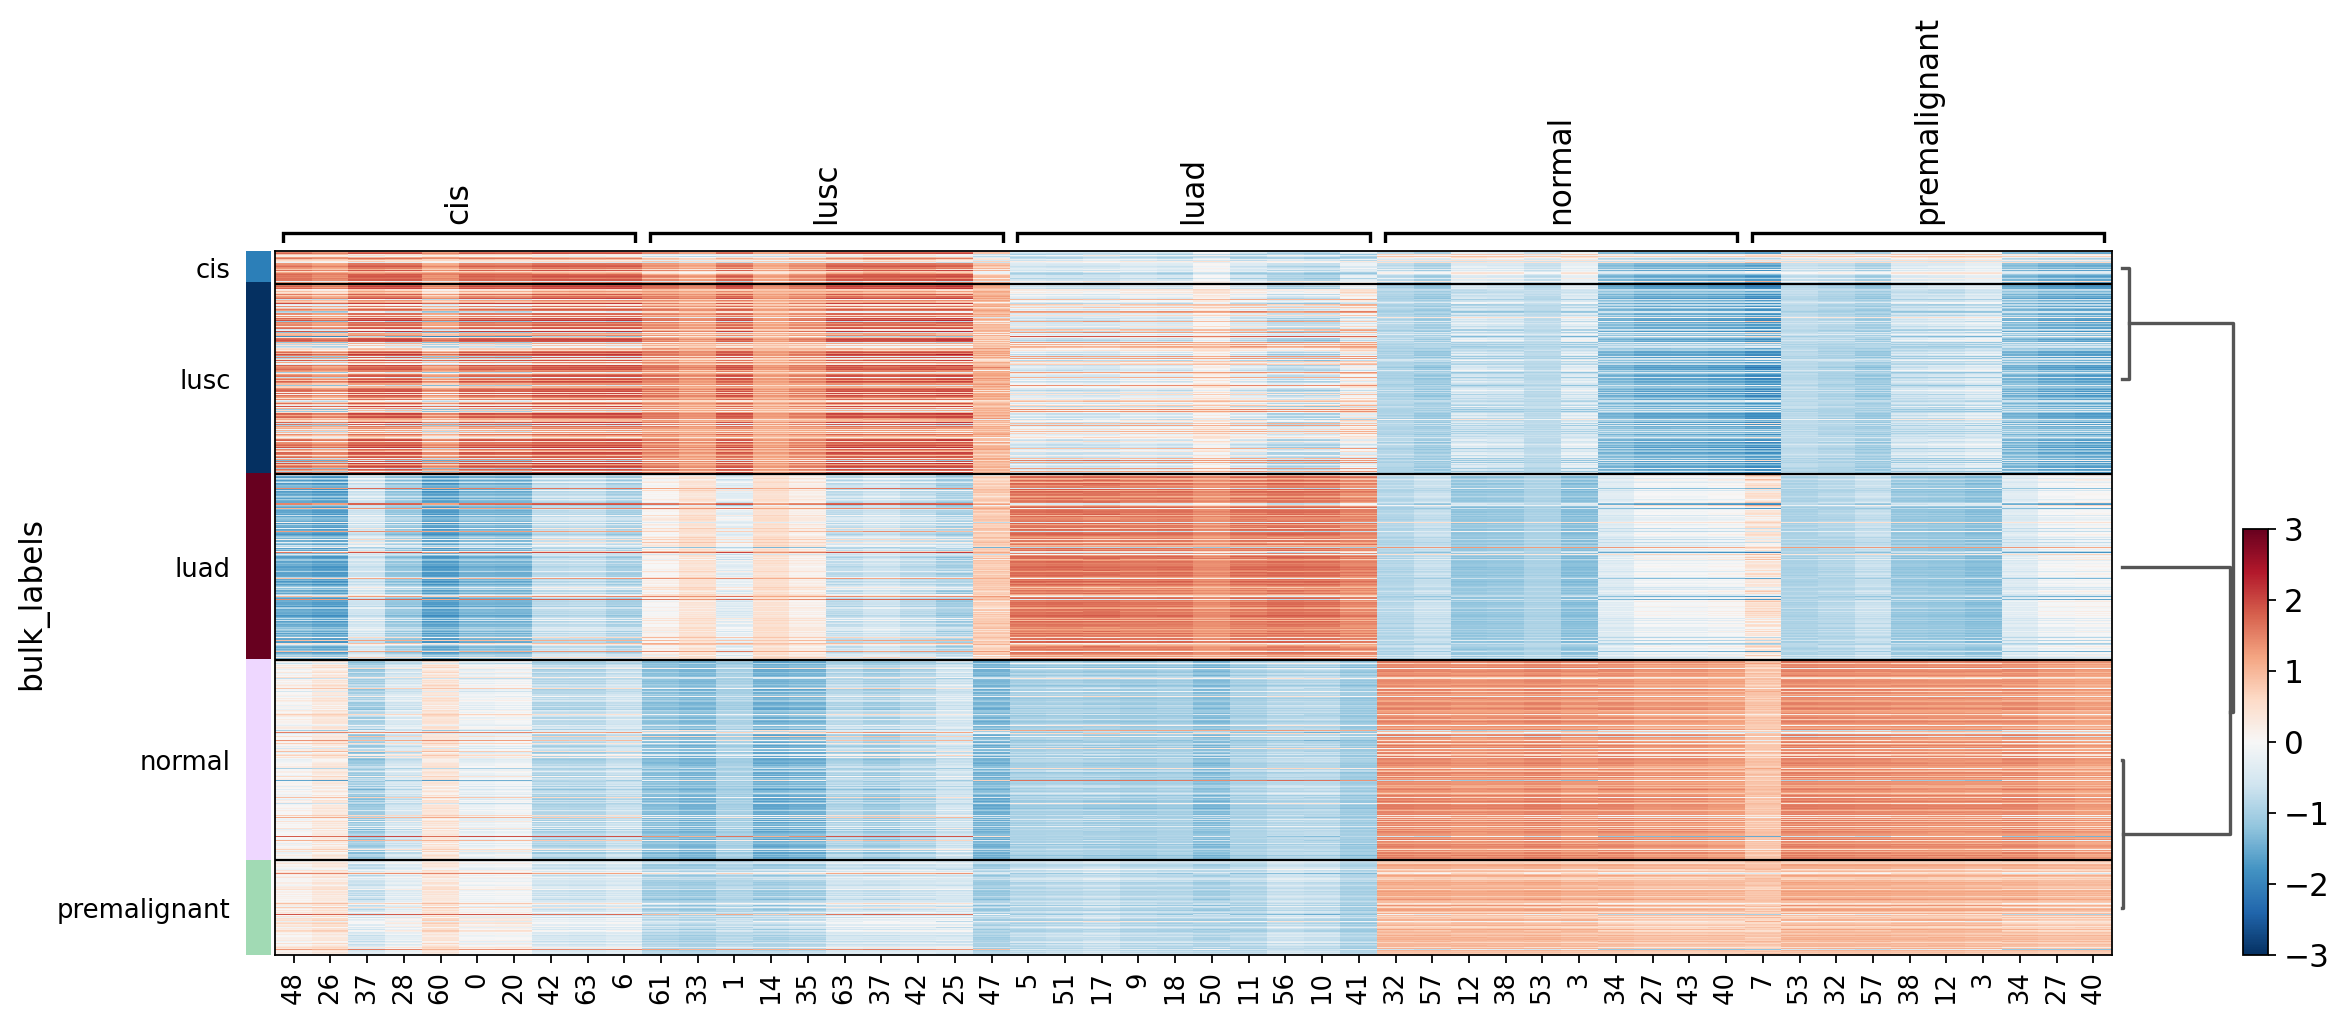

In [74]:
sc.tl.rank_genes_groups(features_adata, groupby='bulk_labels', method='wilcoxon', pts=True, key_added='rank_features_wilcoxon_bulk_labels', layer='scaled')
sc.pl.rank_genes_groups_heatmap(features_adata, show_gene_labels=True, key='rank_features_wilcoxon_bulk_labels', groupby='bulk_labels', vmin=-3, vmax=3, cmap='RdBu_r', layer='scaled', save='rank_features_wilcoxon_bulk_labels.pdf')

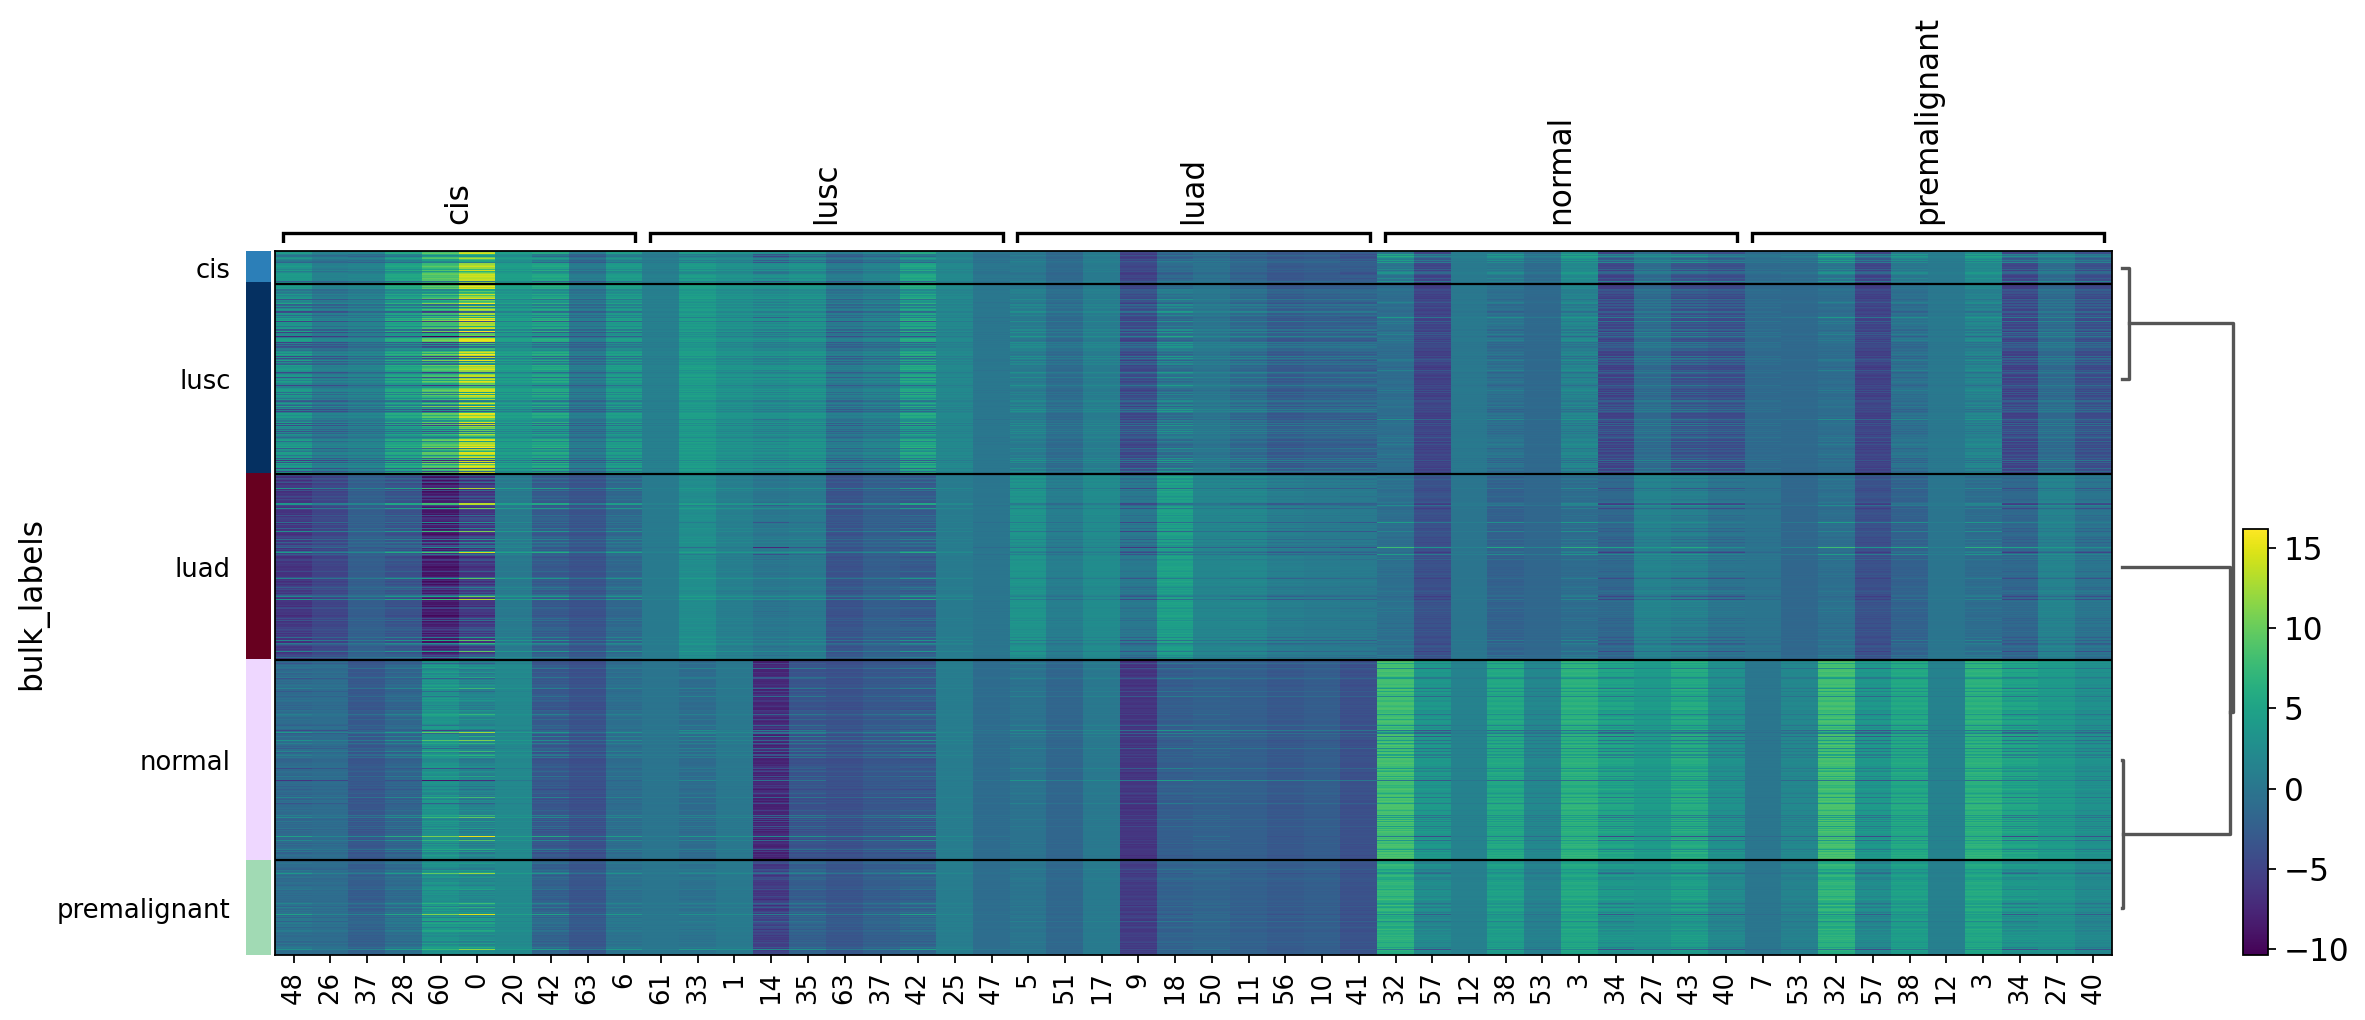

categories: cis, dysplasia, hyperplasia, etc.
var_group_labels: cis, luad, lusc, etc.


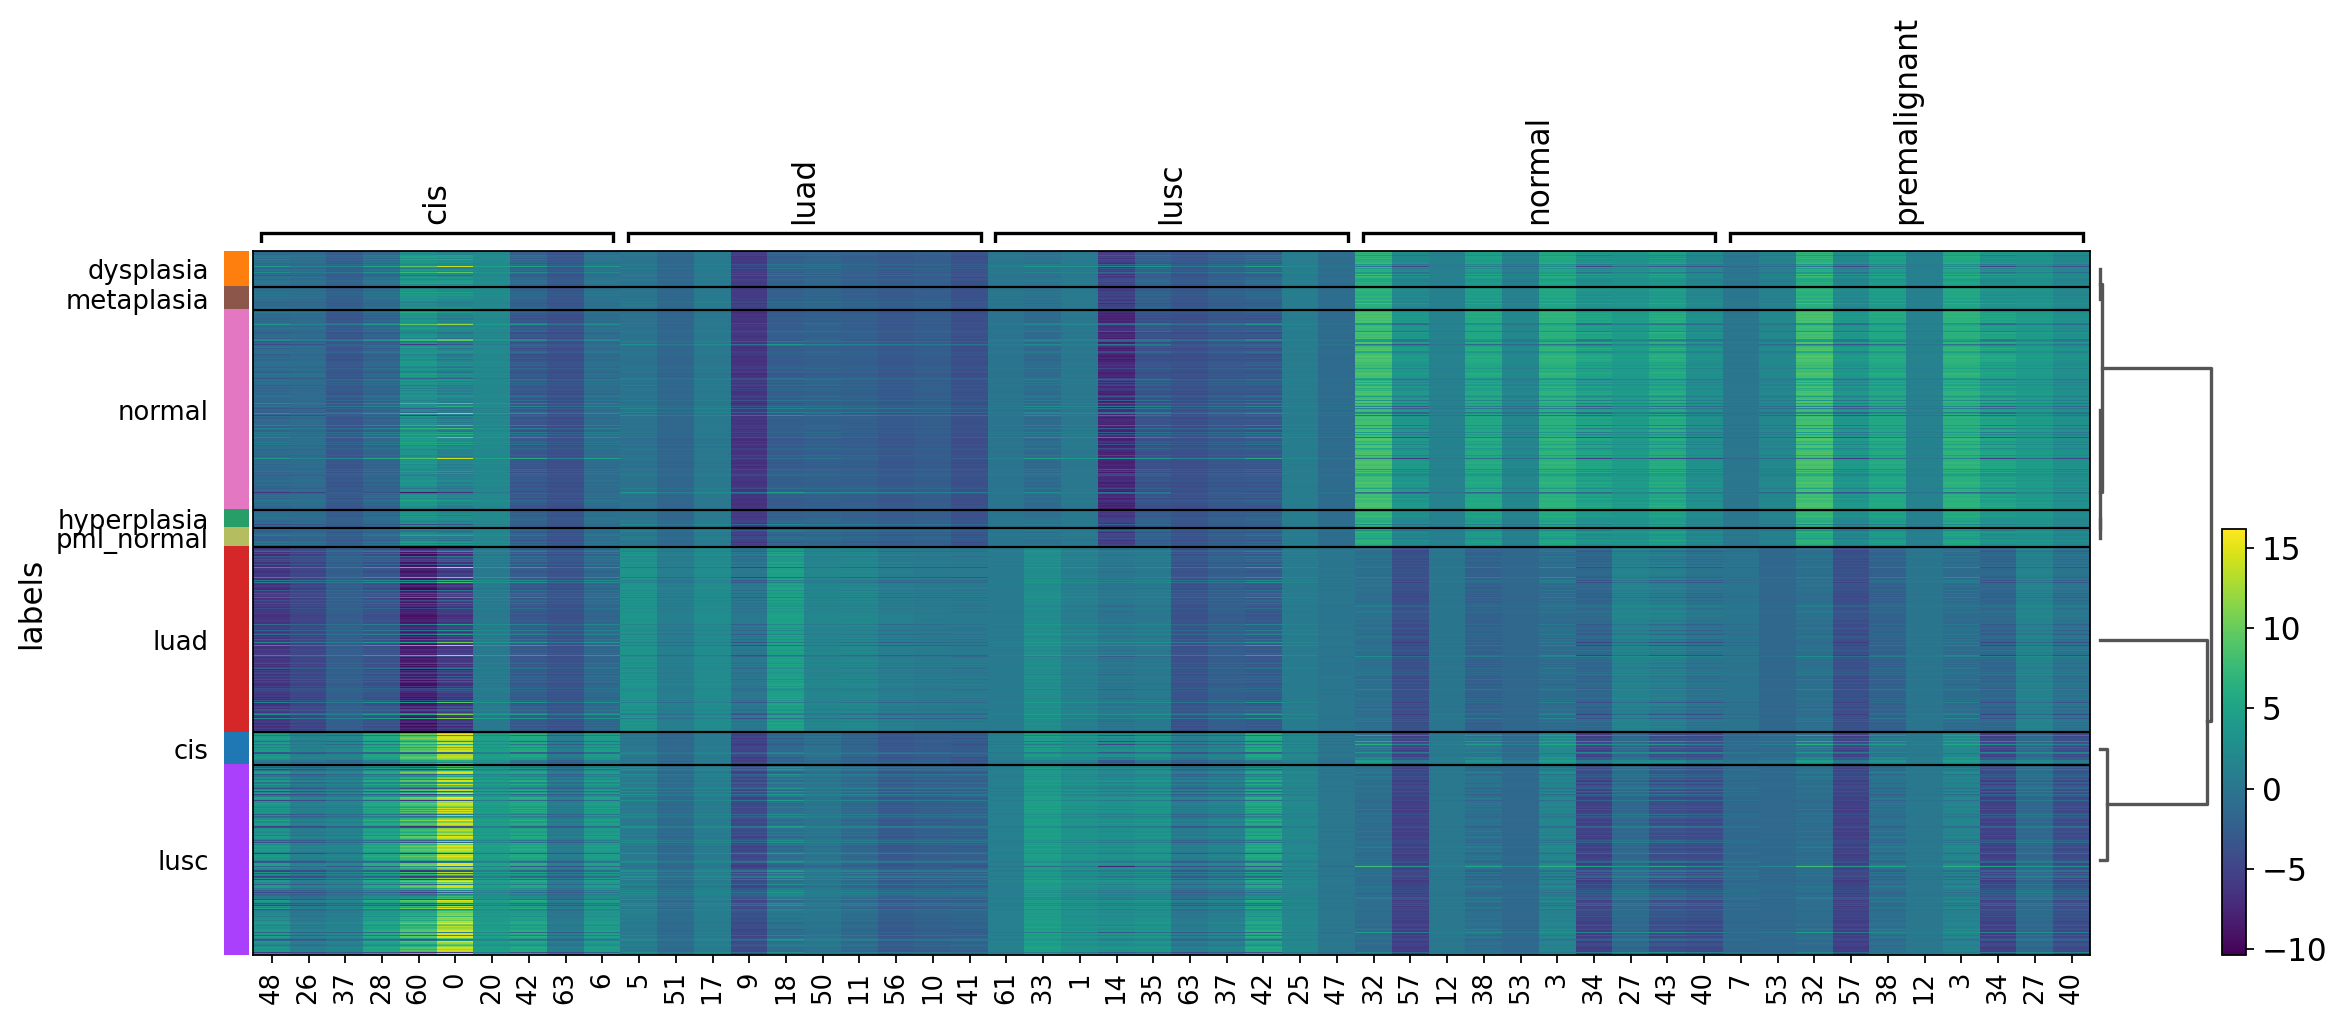

categories: 0, 1, 2, etc.
var_group_labels: cis, luad, lusc, etc.


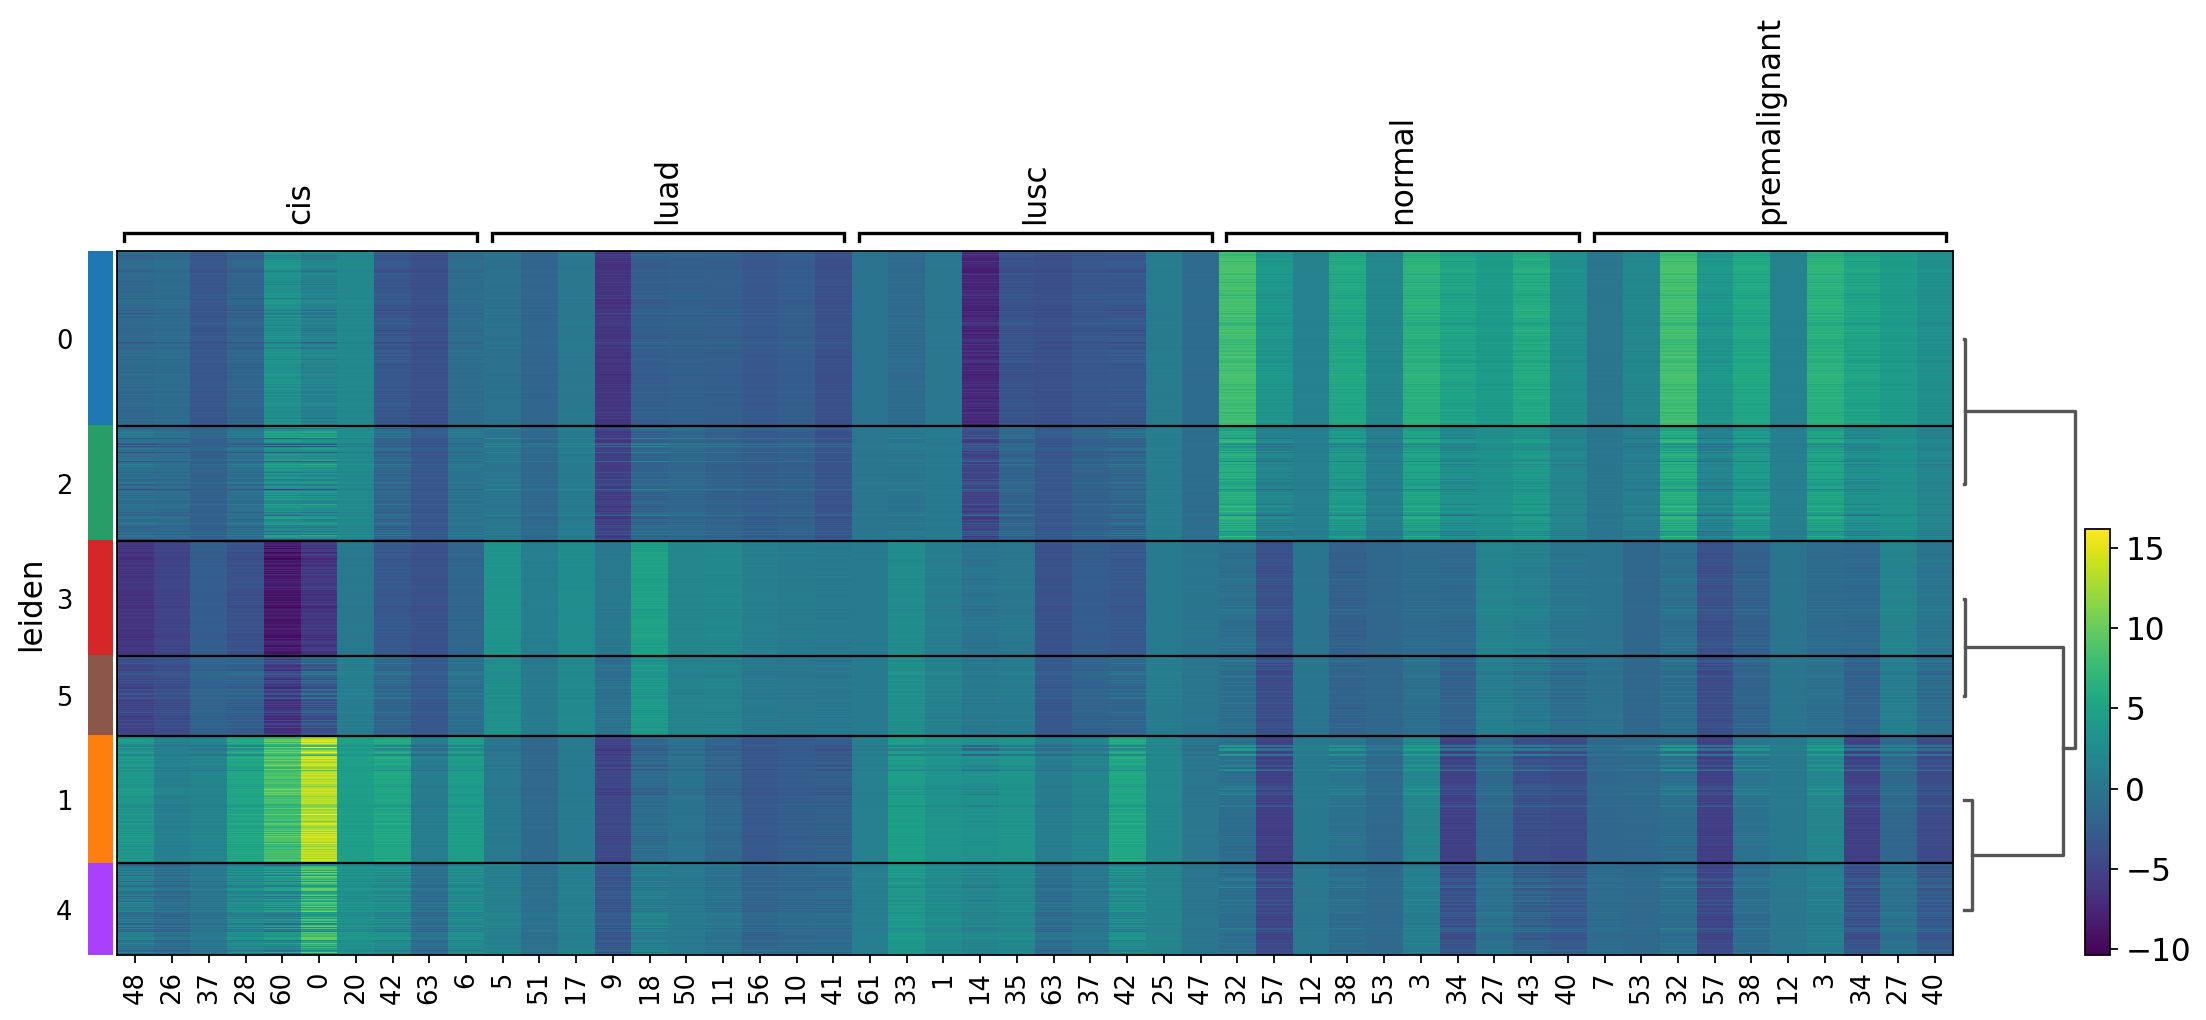

In [75]:
sc.tl.rank_genes_groups(features_adata, groupby='bulk_labels', method='wilcoxon', pts=True, key_added='rank_features_wilcoxon_bulk_labels')
sc.pl.rank_genes_groups_heatmap(features_adata, show_gene_labels=True, key='rank_features_wilcoxon_bulk_labels', groupby='bulk_labels')
sc.pl.rank_genes_groups_heatmap(features_adata, show_gene_labels=True, key='rank_features_wilcoxon_bulk_labels', groupby='labels')
sc.pl.rank_genes_groups_heatmap(features_adata, show_gene_labels=True, key='rank_features_wilcoxon_bulk_labels', groupby='leiden')

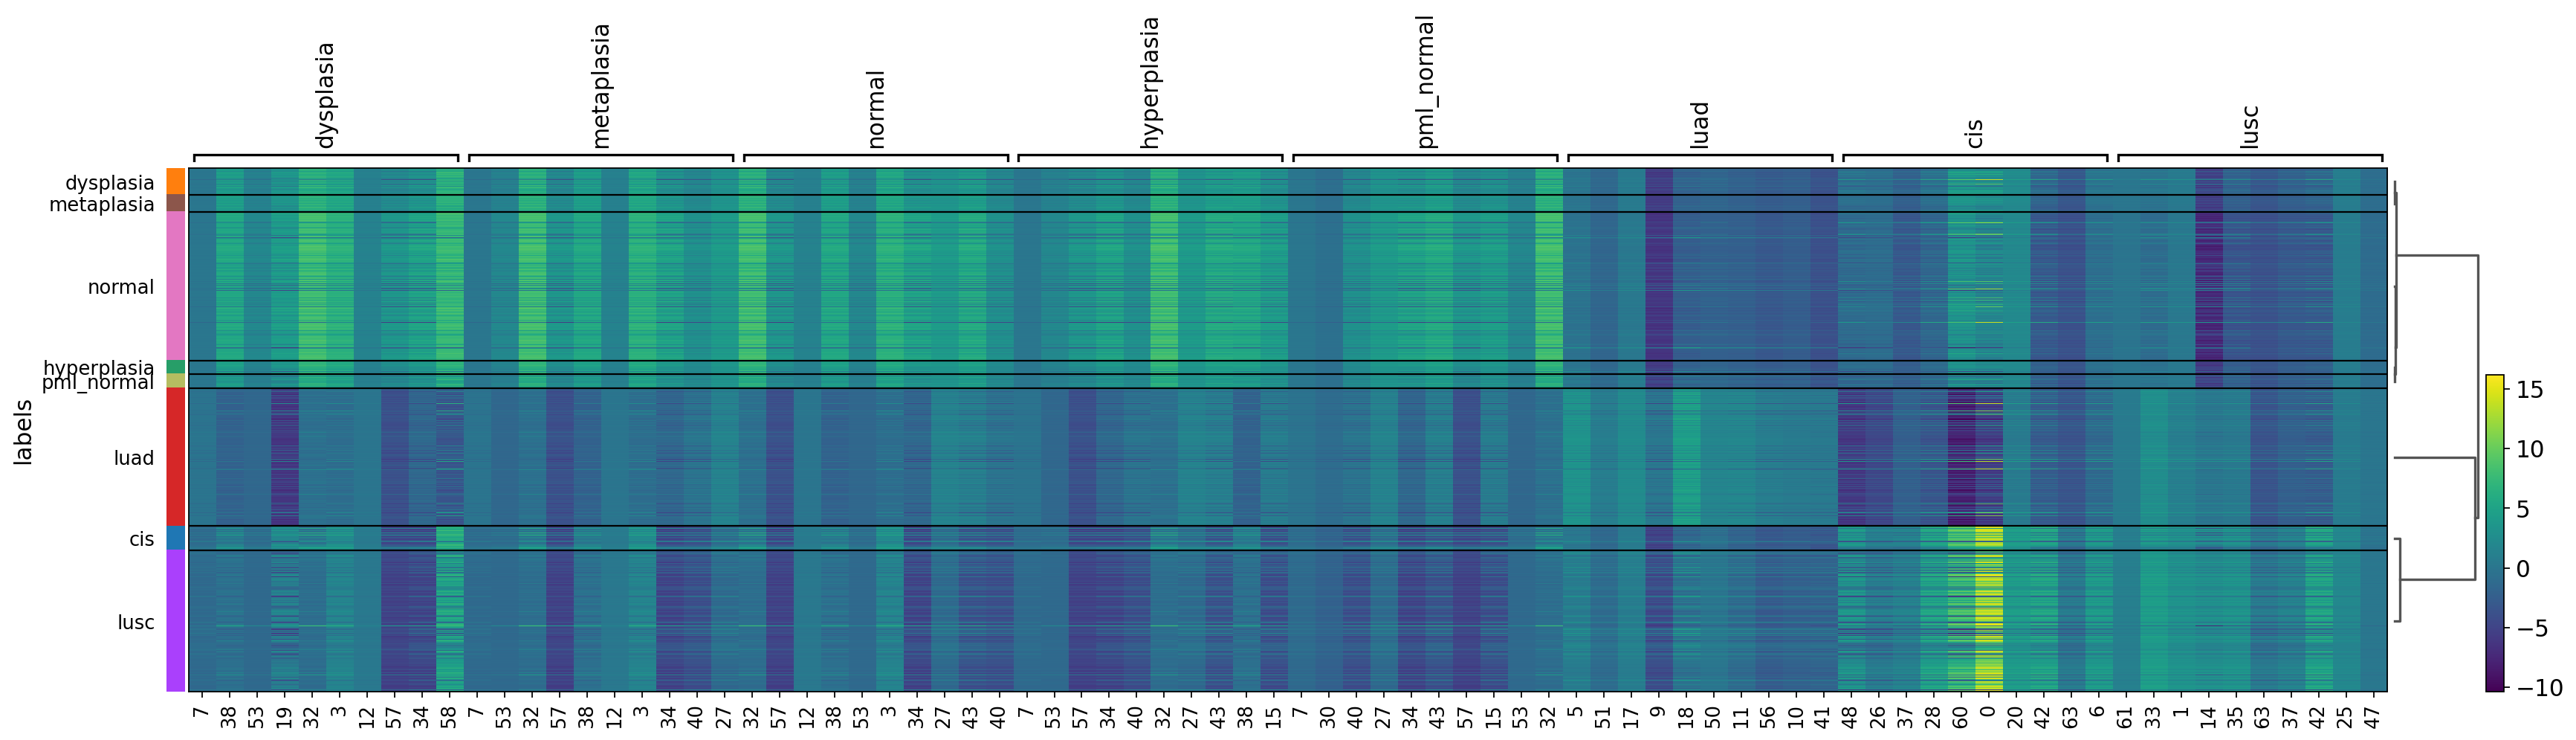

In [76]:
sc.tl.rank_genes_groups(features_adata, groupby='labels', method='wilcoxon', pts=True, key_added='rank_features_wilcoxon_labels')
sc.pl.rank_genes_groups_heatmap(features_adata, show_gene_labels=True, key='rank_features_wilcoxon_labels', groupby='labels')

In [77]:
features_adata.obs['bulk_merge_labels'].value_counts()

normal          719
lusc            685
luad            667
premalignant    458
Name: bulk_merge_labels, dtype: int64

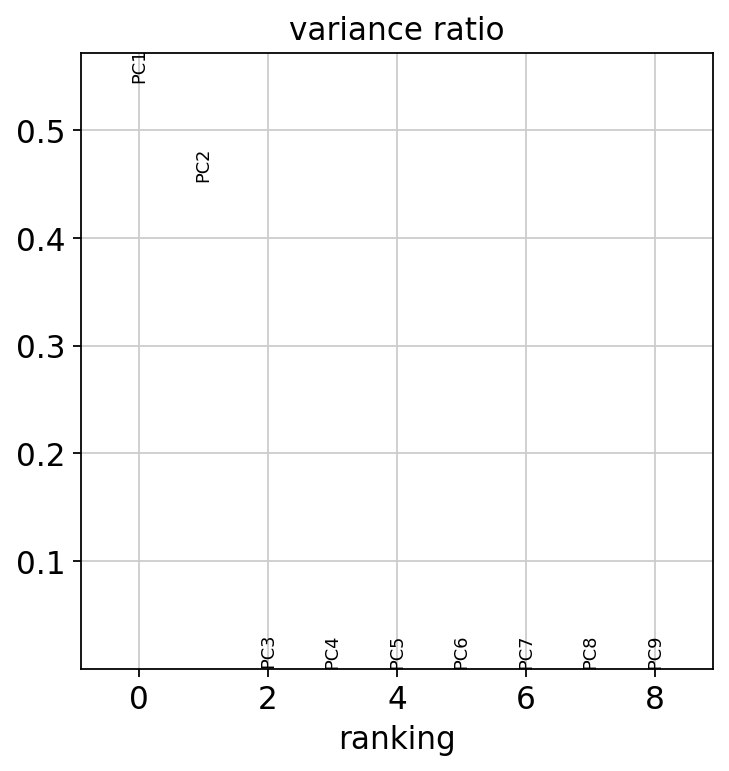

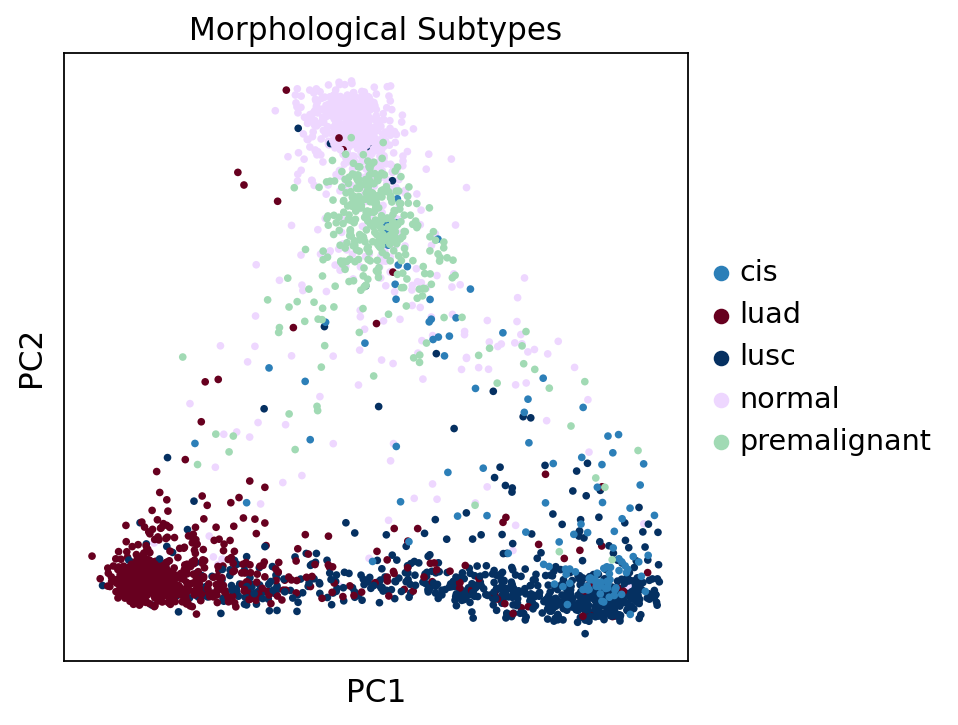

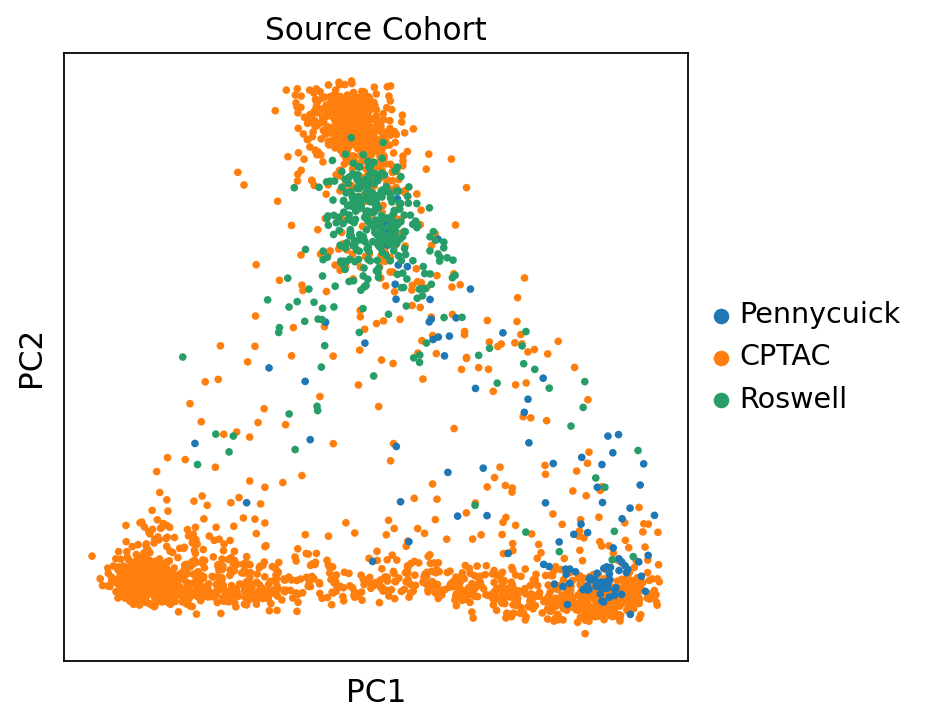

In [78]:
sc.pl.pca_variance_ratio(features_adata, n_pcs=8, show=True)
sc.pl.pca(features_adata, color=['bulk_labels'], title=['Morphological Subtypes'], frameon=True, wspace=0.4, save='bulk_labels.pdf')
features_adata.obs['cohort_names'].replace(['CIS', 'PCGA'], ['Pennycuick', 'Roswell'], inplace=True)
sc.pl.pca(features_adata, color=['cohort_names'], title=['Source Cohort'], frameon=True, wspace=0.4, save='cohort_names.pdf')
# sc.pl.pca(features_adata, color=['leiden'], title=['Leiden Clusters'], frameon=True, wspace=0.4, save='leiden_labels.pdf')

['normal', 'lusc', 'luad', 'cis', 'premalignant']
Categories (5, object): ['cis', 'luad', 'lusc', 'normal', 'premalignant']


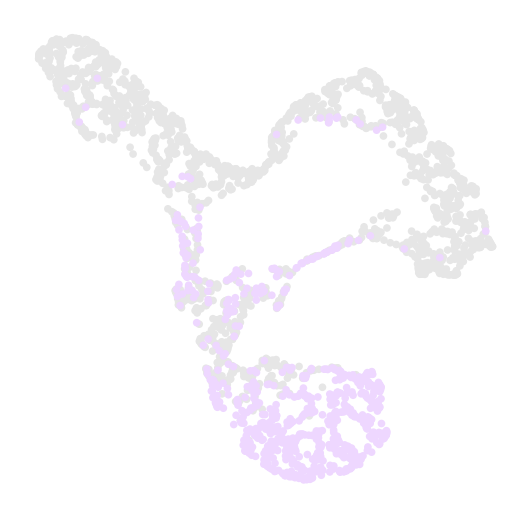

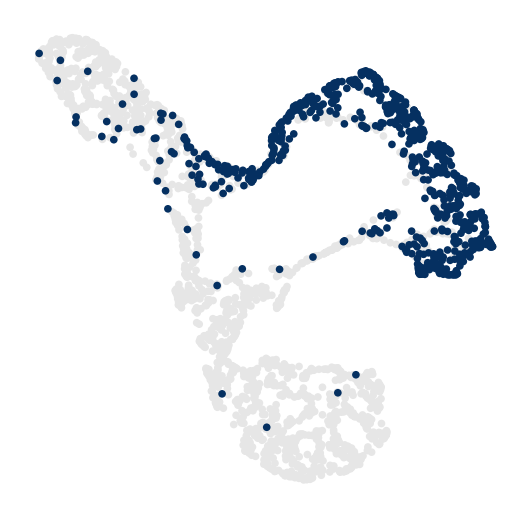

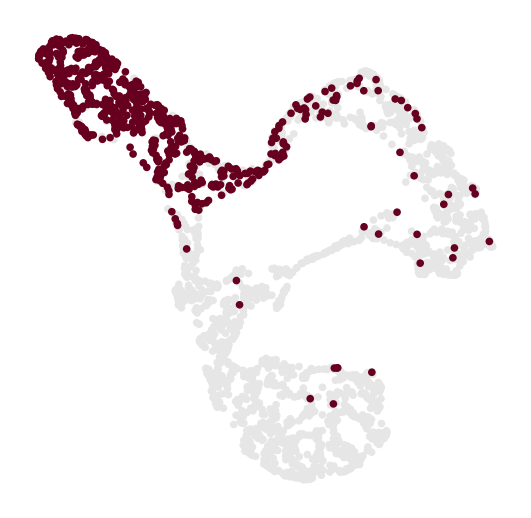

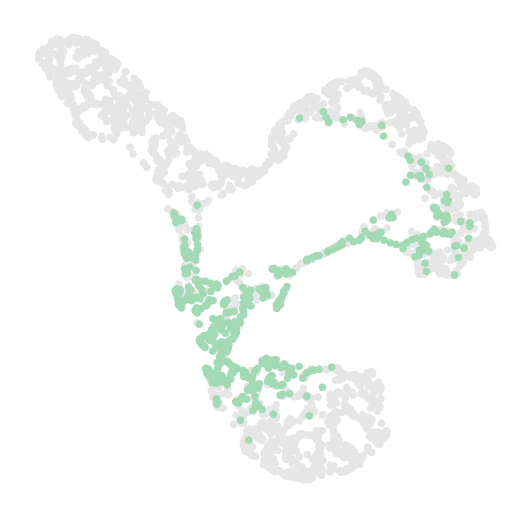

In [79]:
# get unique labels from bulk_labels
print(features_adata.obs['bulk_labels'].unique())
labels_OvA = features_adata.obs['bulk_merge_labels'].unique()
# labels_SvA = [[labels_OvA[0], labels_OvA[1], labels_OvA[2]], labels_OvA[3], labels_OvA[4]]
# Create figure with multiple subplots
# fig, axs = plt.subplots(1, len(labels_OvA), figsize=(6 * len(labels_OvA), 5))


# # Create a UMAP plot for each label
for i, label in enumerate(labels_OvA):
    with plt.rc_context({'figure.figsize': (4, 4)}):
        # sc.pl.umap(features_adata, color='bulk_labels', groups=[label], show=False, title='{} vs ALL'.format(label.upper()), na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc='on data', size=30, frameon=True)
        sc.pl.umap(features_adata, color='bulk_merge_labels', groups=label, title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc=None, frameon=False, na_color='0.9', save='{}_only.pdf'.format(label))
    # sc.pl.tsne(features_adata, color='bulk_labels', groups=[label], ax=axs[1][i], show=False, title='{} vs ALL'.format(label.upper()), na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc='on data', size=30, frameon=True)

# plt.show()
# plt.savefig('Figures/groupby_subtype_clustering.pdf')

In [80]:
labels_OvA = features_adata.obs['bulk_labels'].unique()
labels_SvA = [[labels_OvA[0], labels_OvA[1], labels_OvA[2]], labels_OvA[3], labels_OvA[4]]

temp = features_adata.copy()
temp.uns['bulk_labels_colors'] = ["#2c7fb8", "#67001f", "#053061", "0.8", "#a1dab4"] #
with plt.rc_context({'figure.figsize': (8, 8)}):
    # sc.pl.umap(features_adata, color='bulk_labels', groups=[label], show=False, title='{} vs ALL'.format(label.upper()), na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc='on data', size=30, frameon=True)
    sc.pl.umap(temp, color='bulk_labels', groups=labels_SvA[0], show=False, title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc=None, frameon=False, na_color='w', s=110, save='luad_lusc.pdf')

with plt.rc_context({'figure.figsize': (8, 8)}):
    # sc.pl.umap(features_adata, color='bulk_labels', groups=[label], show=False, title='{} vs ALL'.format(label.upper()), na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc='on data', size=30, frameon=True)
    sc.pl.umap(temp, color='bulk_labels', groups=labels_SvA[1], show=False, title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc=None, frameon=False, na_color='0.9', s=110, save='cis.pdf')

with plt.rc_context({'figure.figsize': (8, 8)}):
    # sc.pl.umap(features_adata, color='bulk_labels', groups=[label], show=False, title='{} vs ALL'.format(label.upper()), na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc='on data', size=30, frameon=True)
    sc.pl.umap(temp, color='bulk_labels', groups=labels_SvA[2], show=False, title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, legend_loc=None, frameon=False, na_color='0.9', s=110, save='premalignant.pdf')

In [81]:
features_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels'
    uns: 'pca', 'neighbors', 'paga', 'bulk_labels_sizes', 'umap', 'tsne', 'leiden', 'bulk_labels_colors', 'bulk_merge_labels_colors', 'leiden_colors', 'cohort_names_colors', 'umap_density_labels_params', 'dendrogram_bulk_labels', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'labels_colors', 'dendrogram_labels', 'dendrogram_leiden', 'rank_features_wilcoxon_labels'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'distances', 'connectivities'

In [82]:
pca = features_adata.obsm['X_pca']
features_pca_adata = ad.AnnData(pca, obs=features_adata.obs, 
                             uns={'neighbors': features_adata.uns['neighbors'], 'pca': features_adata.uns['pca'], 'tsne': features_adata.uns['tsne'], 'umap': features_adata.uns['umap']},
                             obsm={'X_pca': features_adata.obsm['X_pca'], 'X_tsne': features_adata.obsm['X_tsne'], 'X_umap': features_adata.obsm['X_umap']}, 
                             obsp={'connectivities': features_adata.obsp['connectivities'], 'distances': features_adata.obsp['distances']})
features_pca_adata.var_names = ['PC_{}'.format(i) for i in features_pca_adata.var_names]
features_pca_adata

AnnData object with n_obs × n_vars = 2529 × 50
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels'
    uns: 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

In [83]:
categories_order=['normal', 'pml_normal', 'hyperplasia', 'metaplasia', 'dysplasia', 'cis', 'lusc', 'luad']
features_pca_adata.obs["labels"] = pd.Categorical(features_pca_adata.obs["labels"], categories = categories_order)

# df.sort_values(by = "month")
sorted_idx = features_pca_adata.obs['labels'].sort_values().index

features_pca_adata = features_pca_adata[sorted_idx]
features_pca_adata.obs['labels']

Slide_Name
C3L-02660-26    normal
C3L-04856-26    normal
C3L-04365-28    normal
C3L-04872-27    normal
C3L-04880-28    normal
                 ...  
C3N-00574-24      luad
C3N-01408-24      luad
C3N-01414-24      luad
C3L-03976-22      luad
C3L-03268-23      luad
Name: labels, Length: 2529, dtype: category
Categories (8, object): ['normal', 'pml_normal', 'hyperplasia', 'metaplasia', 'dysplasia', 'cis', 'lusc', 'luad']

In [84]:
categories_order=['normal', 'premalignant', 'cis', 'lusc', 'luad']
features_pca_adata.obs["bulk_labels"] = pd.Categorical(features_pca_adata.obs["bulk_labels"], categories = categories_order)

# df.sort_values(by = "month")
sorted_idx = features_pca_adata.obs['bulk_labels'].sort_values().index

features_pca_adata = features_pca_adata[sorted_idx]
features_pca_adata.obs['bulk_labels']

Slide_Name
C3L-02660-26    normal
C3N-02434-27    normal
C3L-00568-26    normal
C3N-00572-27    normal
C3N-02494-22    normal
                 ...  
C3N-00737-23      luad
C3N-00169-22      luad
C3N-03052-22      luad
C3N-01416-22      luad
C3L-03268-23      luad
Name: bulk_labels, Length: 2529, dtype: category
Categories (5, object): ['normal', 'premalignant', 'cis', 'lusc', 'luad']

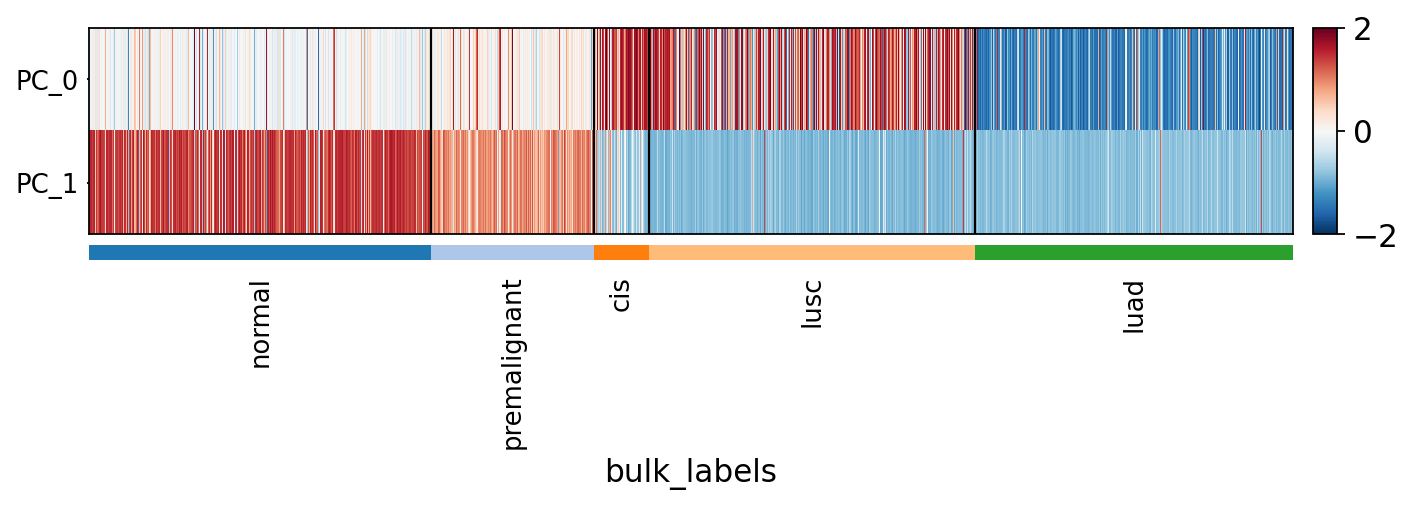

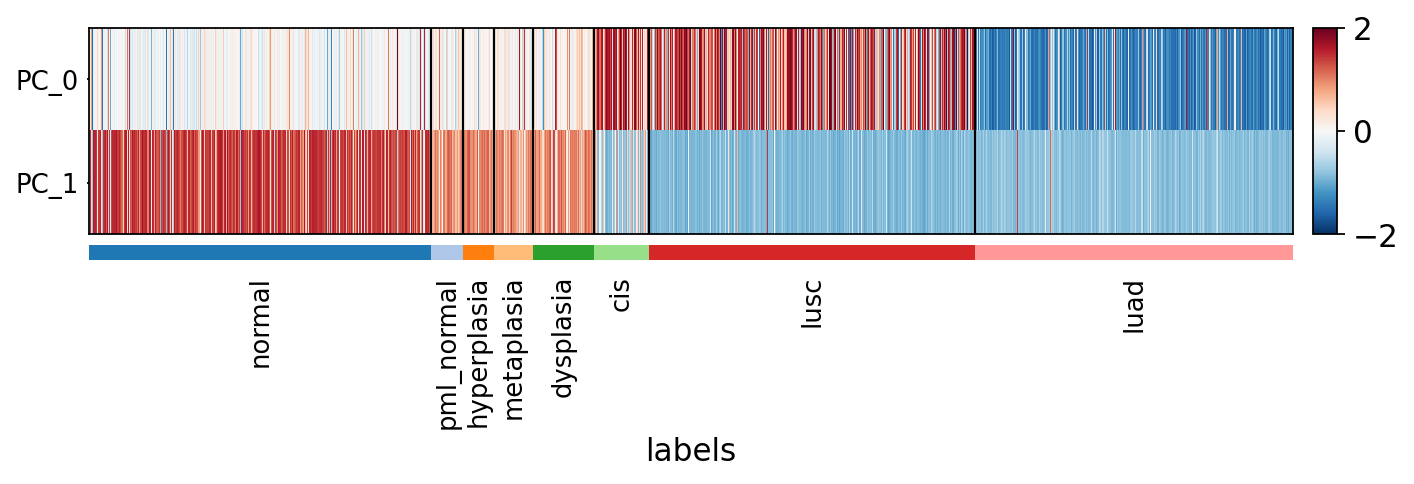

In [85]:
features_pca_adata.layers['scaled'] = sc.pp.scale(features_pca_adata, copy=True).X
plotting_obs_keys = ['cohort_names', 'labels', 'bulk_labels', 'model_predictions']
# for key in plotting_obs_keys:
sc.pl.heatmap(features_pca_adata, var_names=features_pca_adata.var_names[0:2], groupby=['bulk_labels'], swap_axes=True, figsize=(10, 2), layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r', save='_heatmap_bulk_labels.pdf') # categories_order=['normal', 'premalignant', 'cis', 'lusc', 'luad'],
sc.pl.heatmap(features_pca_adata, var_names=features_pca_adata.var_names[0:2], groupby=['labels'], swap_axes=True, figsize=(10, 2), layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r', save='_heatmap_labels.pdf')


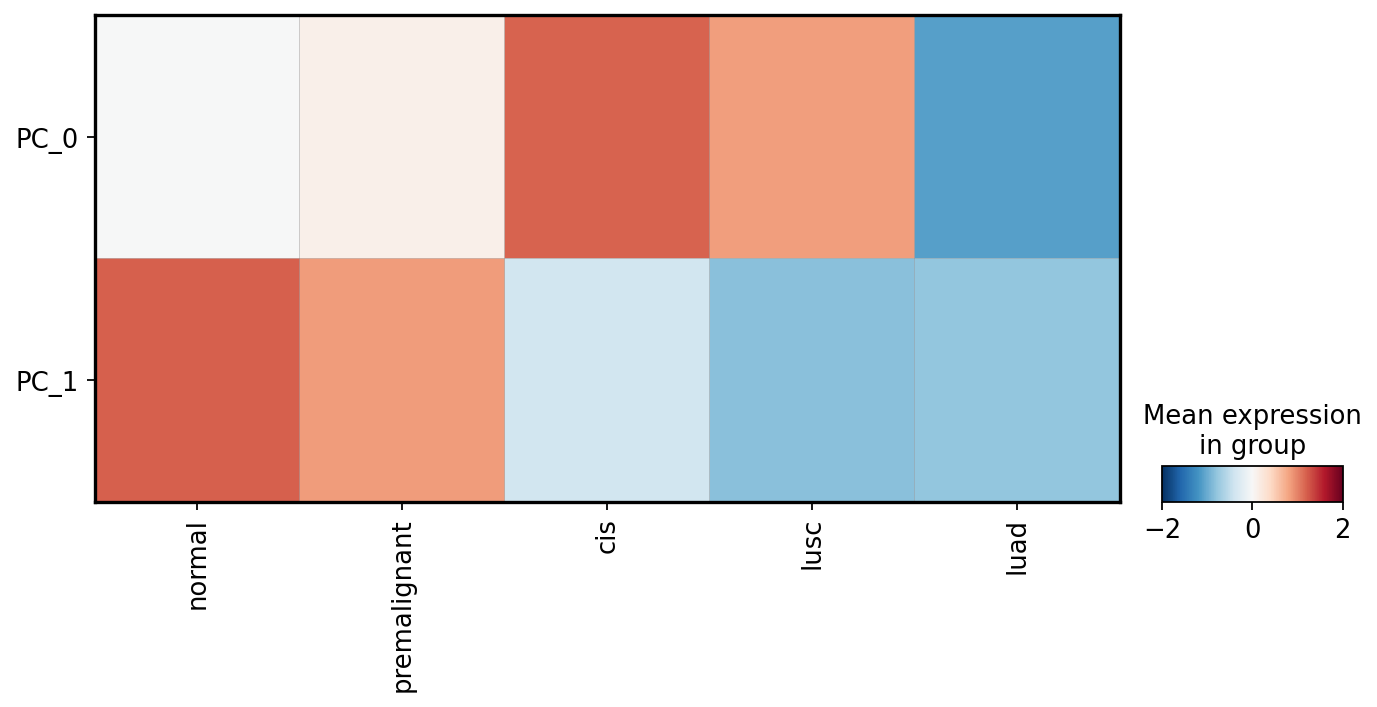

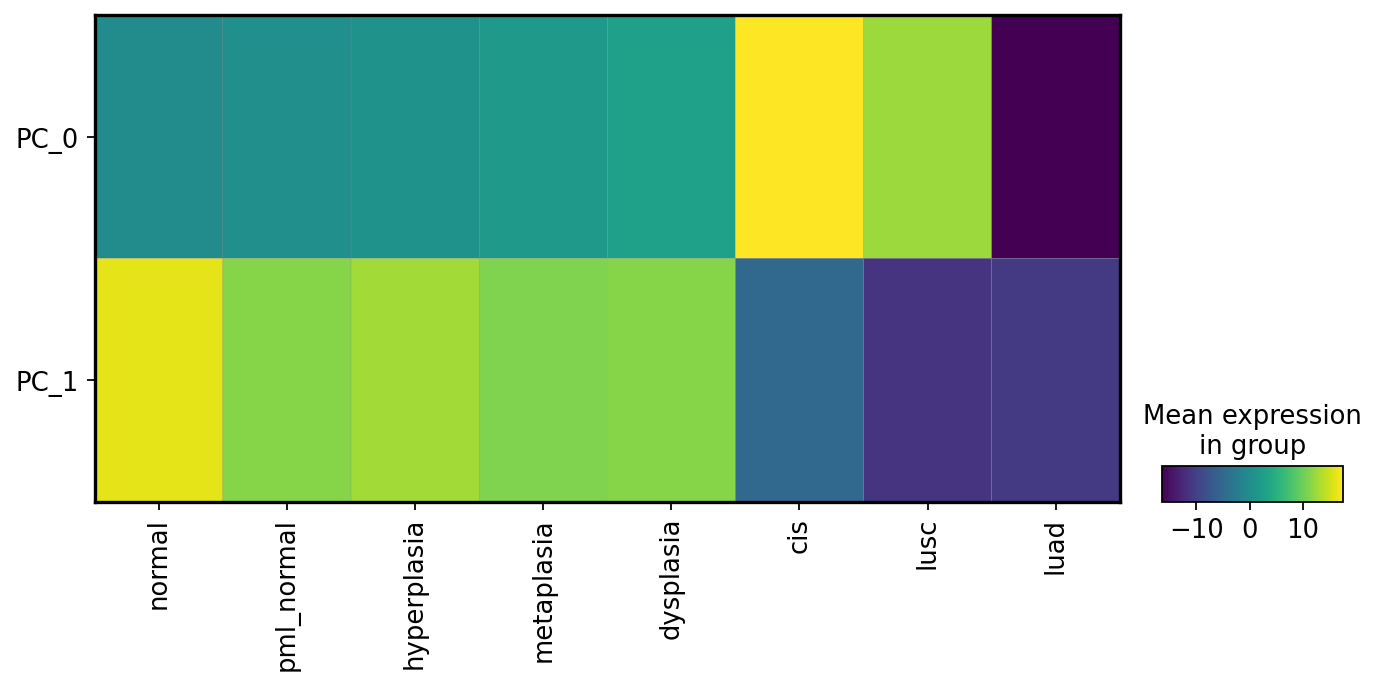

In [86]:
# for key in plotting_obs_keys:
#     sc.pl.matrixplot(features_pca_adata, var_names=features_pca_adata.var_names[0:2], groupby=[key], swap_axes=False, cmap='viridis', colorbar_title='Mean PC value')

sc.pl.matrixplot(features_pca_adata, var_names=features_pca_adata.var_names[0:2], groupby=['bulk_labels'], swap_axes=True, dendrogram=False, figsize=(10, 4), layer='scaled', vmin=-2, vmax=2, cmap='RdBu_r')
sc.pl.matrixplot(features_pca_adata, var_names=features_pca_adata.var_names[0:2], groupby=['labels'], swap_axes=True, dendrogram=False, figsize=(10, 4), categories_order=['normal', 'pml_normal', 'hyperplasia', 'metaplasia', 'dysplasia', 'cis', 'lusc', 'luad'])
# categories_order=['normal', 'pml_normal', 'hyperplasia', 'metaplasia', 'dysplasia', 'cis', 'lusc', 'luad'],

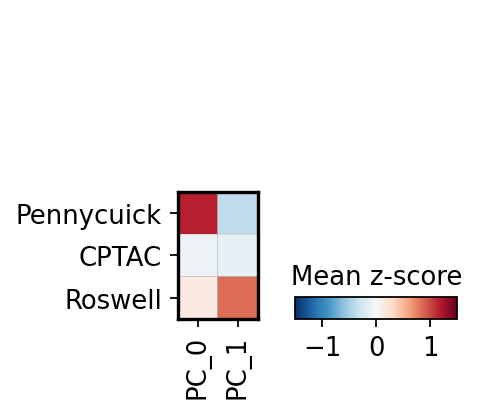

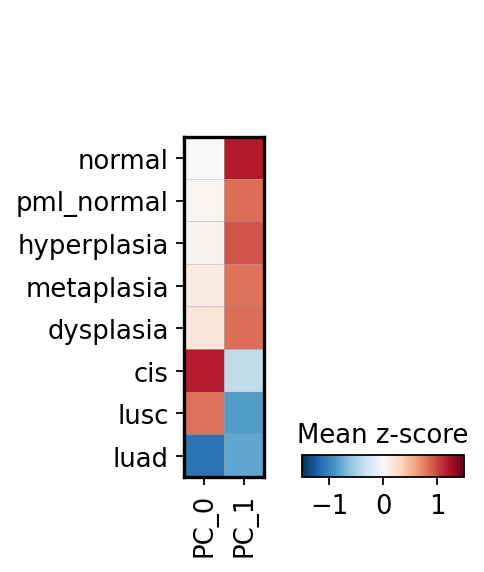

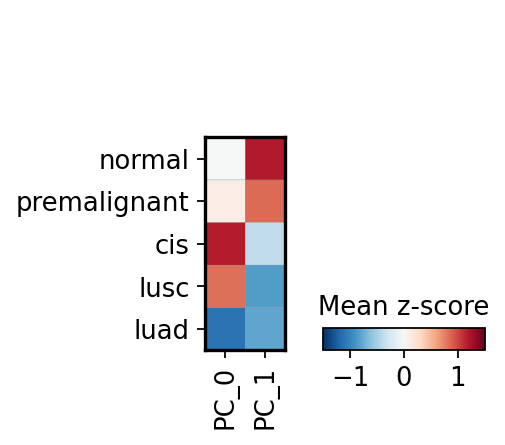

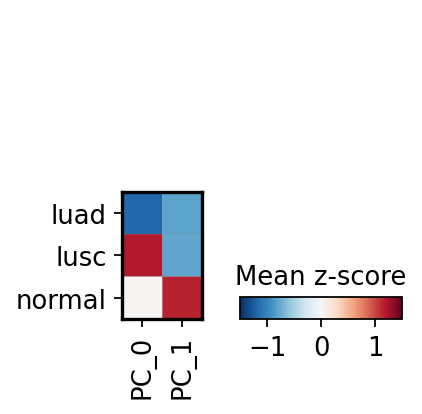

In [87]:
for key in plotting_obs_keys:
    sc.pl.matrixplot(features_pca_adata, var_names=features_pca_adata.var_names[0:2], groupby=[key], swap_axes=False, colorbar_title='Mean z-score', layer='scaled', vmin=-1.5, vmax=1.5, cmap='RdBu_r')

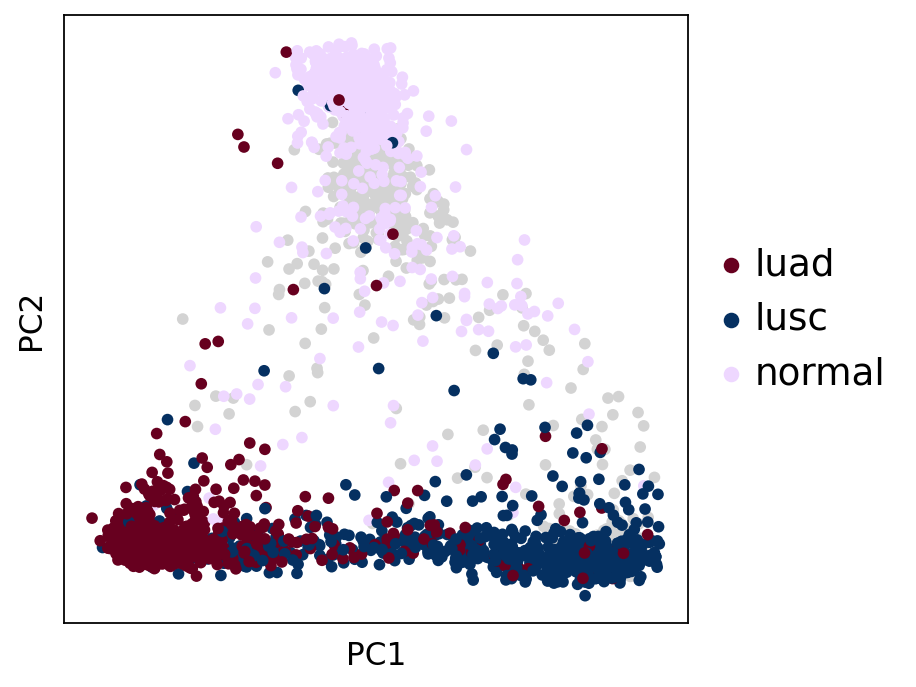

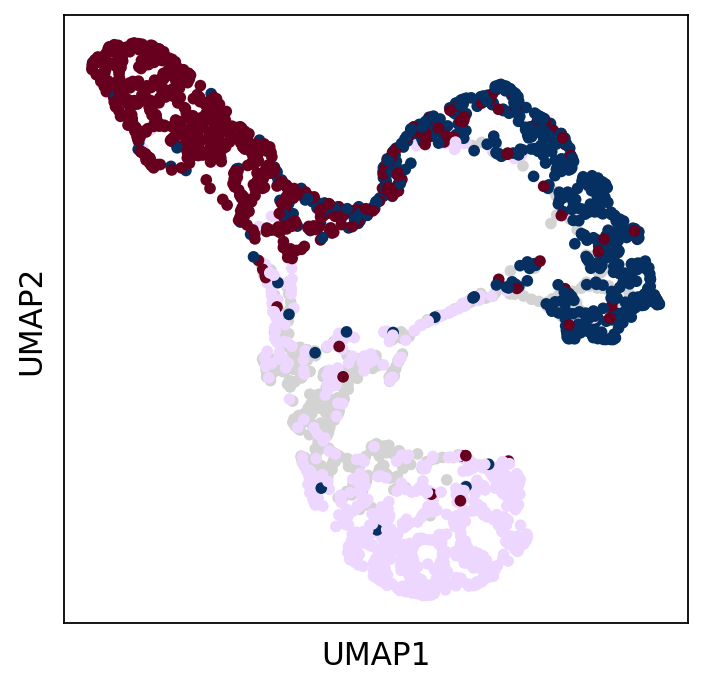

In [88]:
sc.pl.pca(features_adata, color='bulk_labels', groups=['normal', 'lusc', 'luad'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110, save='_lusc_luad_normal.pdf') #
sc.pl.umap(features_adata, color='bulk_labels', groups=['normal', 'lusc', 'luad'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110, legend_loc=None, save='_lusc_luad_normal.pdf') #

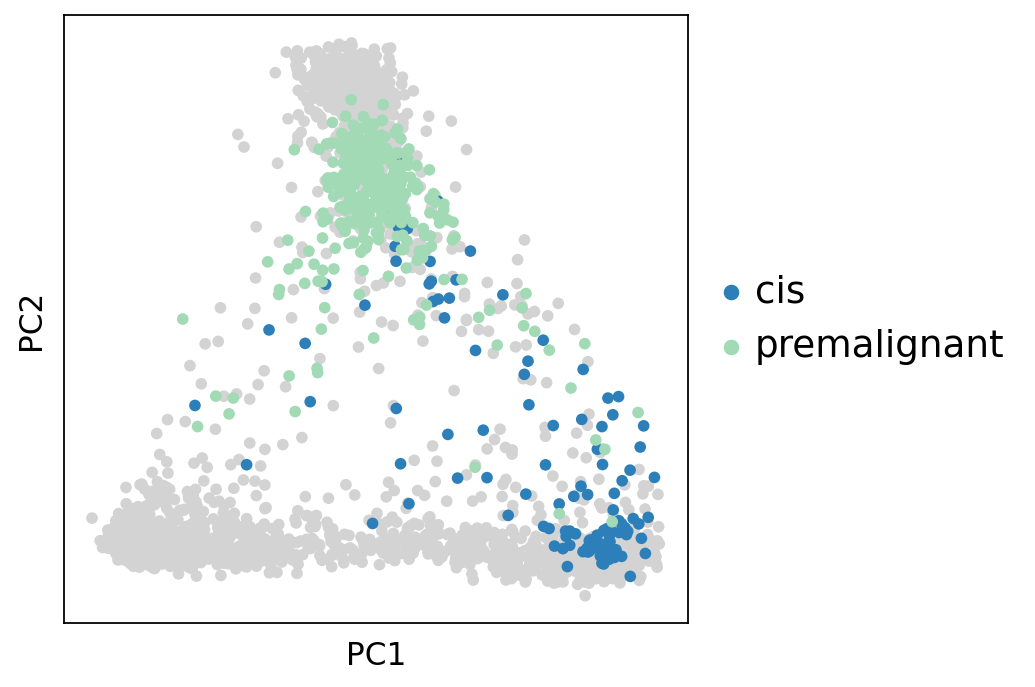

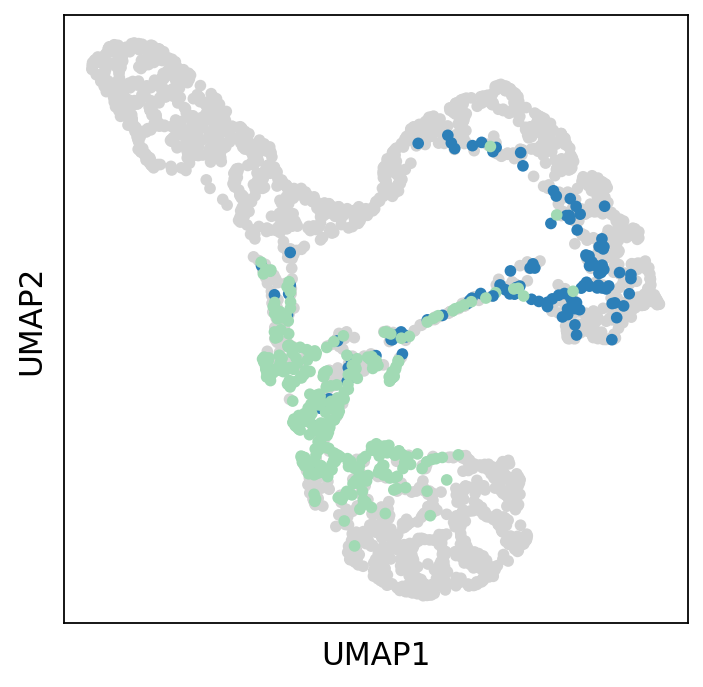

In [89]:
sc.pl.pca(features_adata, color='bulk_labels', groups=['cis', 'premalignant'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110, save='cis_premalignant.pdf') #
sc.pl.umap(features_adata, color='bulk_labels', groups=['cis', 'premalignant'], title='', na_in_legend=False, legend_fontsize='large', legend_fontoutline=2, frameon=True, s=110, legend_loc=None, save='cis_premalignant.pdf') #

In [90]:
features_adata.obs['pc1'] = features_adata.obsm['X_pca'][:, 0]
features_adata.obs['pc2'] = features_adata.obsm['X_pca'][:, 1]

features_adata.obs[['cohort_names', 'labels', 'bulk_labels', 'pc1', 'pc2']].to_csv('tables/pca_datamatrix.csv')

In [91]:
features_adata.write_h5ad(os.path.join(features_path, 'all_samples_adata.h5ad'))

In [92]:
features_adata

AnnData object with n_obs × n_vars = 2529 × 64
    obs: 'cohort_names', 'labels', 'bulk_labels', 'model_predictions', 'leiden', 'bulk_merge_labels', 'umap_density_labels', 'pc1', 'pc2'
    uns: 'pca', 'neighbors', 'paga', 'bulk_labels_sizes', 'umap', 'tsne', 'leiden', 'bulk_labels_colors', 'bulk_merge_labels_colors', 'leiden_colors', 'cohort_names_colors', 'umap_density_labels_params', 'dendrogram_bulk_labels', 'rank_features_ttest_bulk_labels', 'rank_features_wilcoxon_bulk_labels', 'labels_colors', 'dendrogram_labels', 'dendrogram_leiden', 'rank_features_wilcoxon_labels'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    varm: 'PCs'
    layers: 'scaled'
    obsp: 'distances', 'connectivities'